# Human Pose Estimation with Simple Baseline and Pose-Driven Action Recognition



### Nicola Bazzani and Sara Pangrazio, 21/01/2026

In this project we address the problem of human pose estimation from still images through the implementation of a simple pipeline. Starting from raw RGB images of the LSP Dataset, our code predicts the 2D location of human body keypoints and evaluates their accuracy using standard pose estimation metrics (PCJ and PCP).

Once the pose estimation stage is completed, the predicted joint coordinates are used as the basis for an action recognition task. Since the LSP dataset does not provide action annotations, we first generate pseudo-labels by applying K-means clustering to these features.

Using the same pose-derived features, we then train and evaluate several classifiers, including neural models (MLPs) and classical machine learning method such as Random Forests. In addition, we also test the same classification pipeline using a set of manually annotated action labels.

### We import packages and set seeds

In [ ]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
from torchvision.models import resnet50, resnet18
import torch.optim as optim
from PIL import Image

from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import random
import numpy as np
import copy
import time
import os
import cv2
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import silhouette_score, adjusted_rand_score

# For results
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from scipy.io import loadmat

In [ ]:
def set_seed(seed, use_gpu = True):
    """
    Set SEED for PyTorch reproducibility
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_gpu:
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 44

USE_SEED = True

if USE_SEED:
    set_seed(SEED, torch.cuda.is_available())

### We load all the necessary data:

In [ ]:
# checkpoints for saved models
!unzip -q  checkpoints.zip -d /content/checkpoints

In [ ]:
!unzip -q Dataset_project.zip -d /content/dataset_project

In [ ]:
ROOT = "/content/dataset_project"
IMAGES_PATH = os.path.join(ROOT, "images")
JOINTS_PATH = os.path.join(ROOT, "joints.mat")

In [ ]:
mat = loadmat(JOINTS_PATH)
joints_names = ['Right ankle','Right knee','Right hip','Left hip','Left knee','Left ankle','Right wrist','Right elbow','Right shoulder','Left shoulder','Left elbow','Left wrist','Neck','Head top']
joints = mat['joints']
joints = np.transpose(np.array(joints), (2, 1, 0))
joints.shape

def get_image(image_path):
    return Image.open(image_path)

In [ ]:
image_files = sorted([
    os.path.join(IMAGES_PATH, f)
    for f in os.listdir(IMAGES_PATH)
    if f.lower().endswith('.jpg')
])

# loading images

images = [np.array(get_image(p)) for p in image_files]

### We define all utility functions:

We define all functions necessary to transform and rescale the data: images were resized to dimension (192,256) using an affine transformation based on the ground-truth joint bounding box.

Ground-truth heatmaps were generated using 2D gaussian kernels centered in joints, with $\sigma = 2$.

In [ ]:
# Input image resolution (width, height)
IMAGE_SIZE = (192, 256)   # 256x192 (H x W)

# Heatmap resolution (width, height)
HEATMAP_SIZE = (48, 64)   # 64x48 (H x W)

# Gaussian sigma for heatmap generation
SIGMA = 2

# Standard pixel reference used in Simple Baseline
PIXEL_STD = 200.0

# Extra padding around the person bounding box
PADDING = 1.25

# Number of images
N = 2000

def joints_to_center_scale(joints_i, image_size=IMAGE_SIZE):
    """
    Convert LSP joints to (center, scale) parameters.
    LSP convention: v == 0 means the joint is visible.

    joints_i: (J, 3) array with (x, y, v) (original map coords)
    returns: center (2,), scale (2,)
    scale represents person size
    """
    xy = joints_i[:, :2].astype(np.float32)
    v  = joints_i[:, 2].astype(np.float32)

    # Visible joints mask
    visible = (v == 0)

    # Fallback in the unlikely case no joints are visible
    if visible.sum() == 0:
        center = np.array([image_size[0] / 2, image_size[1] / 2], dtype=np.float32)
        scale  = np.array([1.0, 1.0], dtype=np.float32)
        return center, scale

    # Bounding box from visible joints
    x_min, x_max = xy[visible, 0].min(), xy[visible, 0].max()
    y_min, y_max = xy[visible, 1].min(), xy[visible, 1].max()

    w = max(1.0, x_max - x_min)
    h = max(1.0, y_max - y_min)

    center = np.array([x_min + w * 0.5, y_min + h * 0.5], dtype=np.float32)

    # Fix aspect ratio to match network input (4:3)
    aspect_ratio = image_size[0] / image_size[1]
    if w > aspect_ratio * h:
        h = w / aspect_ratio
    elif w < aspect_ratio * h:
        w = h * aspect_ratio

    # Convert to scale (Simple Baseline convention)
    scale = np.array([w / PIXEL_STD, h / PIXEL_STD], dtype=np.float32) * PADDING
    return center, scale


def get_affine_transform(center, scale, rotation, output_size):
    """
    Compute the affine transformation matrix.
    rotation is in degrees (set to 0 for now, no augmentation).
    """
    scale_tmp = scale * PIXEL_STD
    src_w = scale_tmp[0]
    dst_w, dst_h = output_size

    rot_rad = np.pi * rotation / 180

    def rotate_point(pt, rad):
        sn, cs = np.sin(rad), np.cos(rad)
        return np.array([pt[0] * cs - pt[1] * sn,
                         pt[0] * sn + pt[1] * cs], dtype=np.float32)

    src_dir = rotate_point(np.array([0, -0.5 * src_w]), rot_rad)
    dst_dir = np.array([0, -0.5 * dst_w], dtype=np.float32)

    src = np.zeros((3, 2), dtype=np.float32)
    dst = np.zeros((3, 2), dtype=np.float32)

    src[0] = center
    src[1] = center + src_dir
    src[2] = center + np.array([-src_dir[1], src_dir[0]], dtype=np.float32)

    dst[0] = [dst_w * 0.5, dst_h * 0.5]
    dst[1] = dst[0] + dst_dir
    dst[2] = dst[0] + np.array([-dst_dir[1], dst_dir[0]], dtype=np.float32)

    return cv2.getAffineTransform(src, dst)


def affine_transform(point, transform):
    """Apply affine transform to a single (x, y) point."""
    pt = np.array([point[0], point[1], 1.0], dtype=np.float32)
    new_pt = transform @ pt
    return new_pt[:2]


def crop_and_resize_image(image_bgr, center, scale):
    """
    Apply affine transformation to obtain a 256x192 person crop.
    """
    transform = get_affine_transform(center, scale, rotation=0, output_size=IMAGE_SIZE)
    cropped = cv2.warpAffine(
        image_bgr,
        transform,
        IMAGE_SIZE,
        flags=cv2.INTER_LINEAR
    )
    return cropped, transform


def transform_joints(joints_i, transform):
    """
    Transform joint coordinates into cropped image space.
    """
    joints_xy = joints_i[:, :2].astype(np.float32)
    v = joints_i[:, 2]

    joints_xy_out = joints_xy.copy()
    visibility = np.ones((joints_xy.shape[0], 1), dtype=np.float32)

    for j in range(joints_xy.shape[0]):
      joints_xy_out[j] = affine_transform(joints_xy[j], transform)

    return joints_xy_out, visibility

def precompute_joints_crop_all(image_files, joints, N=2000, image_size=(192,256)):
    joints_crop_all = np.zeros((N, joints.shape[1], 2), dtype=np.float32)

    for i in range(N):
        joints_i = joints[i]  # (14,3) in original image coords

        center, scale = joints_to_center_scale(joints_i, image_size=image_size)
        trans = get_affine_transform(center, scale, rotation=0, output_size=image_size)

        joints_xy = joints_i[:, :2].astype(np.float32)
        joints_xy_crop = joints_xy.copy()

        for j in range(joints_xy_crop.shape[0]):
            joints_xy_crop[j] = affine_transform(joints_xy_crop[j], trans)

        joints_crop_all[i] = joints_xy_crop

    return joints_crop_all

joints_crop_all = precompute_joints_crop_all(image_files, joints, N=N, image_size=IMAGE_SIZE)
print("joints_crop_all:", joints_crop_all.shape)  # (2000,14,2)


def generate_heatmaps(joints_xy, joints_vis):
    """
    Generate Gaussian heatmaps for each joint.
    """
    num_joints = joints_xy.shape[0]
    Wm, Hm = HEATMAP_SIZE
    heatmaps = np.zeros((num_joints, Hm, Wm), dtype=np.float32)

    stride = np.array(IMAGE_SIZE) / np.array(HEATMAP_SIZE)
    tmp_size = int(SIGMA * 3)

    size = 2 * tmp_size + 1
    x = np.arange(0, size, 1, np.float32)
    y = x[:, None]
    g = np.exp(-((x - tmp_size)**2 + (y - tmp_size)**2) / (2 * SIGMA**2))

    for j in range(num_joints):

        mu_x = int(joints_xy[j, 0] / stride[0] + 0.5)
        mu_y = int(joints_xy[j, 1] / stride[1] + 5e-1)

        ul = [mu_x - tmp_size, mu_y - tmp_size]
        br = [mu_x + tmp_size + 1, mu_y + tmp_size + 1]

        if ul[0] >= Wm or ul[1] >= Hm or br[0] < 0 or br[1] < 0:
            continue

        g_x = max(0, -ul[0]), min(br[0], Wm) - ul[0]
        g_y = max(0, -ul[1]), min(br[1], Hm) - ul[1]

        img_x = max(0, ul[0]), min(br[0], Wm)
        img_y = max(0, ul[1]), min(br[1], Hm)

        heatmaps[j, img_y[0]:img_y[1], img_x[0]:img_x[1]] = \
            g[g_y[0]:g_y[1], g_x[0]:g_x[1]]

    return heatmaps

joints_crop_all: (2000, 14, 2)


### We Split Data, Create Datasets and Iterators

We split the data into Training Set (70%), Validation Set (10%) and Test Set (20%)

In [ ]:
indices = np.arange(N)
np.random.shuffle(indices)

train_end = int(0.7 * N)
val_end   = int(0.8 * N)

train_idx = indices[:train_end]
val_idx   = indices[train_end:val_end]
test_idx  = indices[val_end:]

We crate Datasets and perform Data Augemtation (scale : $\pm$30%, rotation : $\pm$40 degrees and flip)

In [ ]:
SCALE_FACTOR = 0.30   # ±30%
ROT_FACTOR   = 40     # ±40 degrees
FLIP_PROB    = 0.5

# LSP flip pairs based on joint order:
# ['Right ankle','Right knee','Right hip','Left hip','Left knee','Left ankle',
#  'Right wrist','Right elbow','Right shoulder','Left shoulder','Left elbow','Left wrist','Neck','Head top']
LSP_FLIP_PAIRS = [(0,5),(1,4),(2,3),(6,11),(7,10),(8,9)]  # right<->left

def flip_joints_lsp(joints_xy, width):
    j = joints_xy.copy()
    j[:, 0] = (width - 1) - j[:, 0]
    for a, b in LSP_FLIP_PAIRS:
        j[[a, b]] = j[[b, a]]
    return j

class PoseDatasetAug(Dataset):
    def __init__(self, image_paths, joints_all, indices, is_train=True):
        self.image_paths = image_paths
        self.joints_all = joints_all
        self.indices = indices
        self.is_train = is_train

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, k):
        """ makes it so that img_t , hm_t = dataset[k] """
        idx = self.indices[k]

        img_bgr = cv2.imread(self.image_paths[idx], cv2.IMREAD_COLOR)
        if img_bgr is None:
            raise ValueError(f"Failed to read {self.image_paths[idx]}")

        joints_i = self.joints_all[idx]            # (J,3) original coords
        joints_xy = joints_i[:, :2].astype(np.float32)

        center, scale = joints_to_center_scale(joints_i, image_size=IMAGE_SIZE)

        r = 0.0
        if self.is_train:
            # scale jitter
            sf = SCALE_FACTOR
            scale = scale * np.clip(np.random.randn() * sf + 1, 1 - sf, 1 + sf)

            # rotation jitter (like their code)
            rf = ROT_FACTOR
            if random.random() <= 0.6:
                r = np.clip(np.random.randn() * rf, -2*rf, 2*rf)
            else:
                r = 0.0

            # flip
            if random.random() < FLIP_PROB:
                img_bgr = img_bgr[:, ::-1, :].copy()
                w = img_bgr.shape[1]
                joints_xy = flip_joints_lsp(joints_xy, width=w)
                center[0] = (w - 1) - center[0]

        trans = get_affine_transform(center, scale, rotation=r, output_size=IMAGE_SIZE)
        crop_bgr = cv2.warpAffine(img_bgr, trans, IMAGE_SIZE, flags=cv2.INTER_LINEAR)

        # transform ALL joints to crop space
        joints_xy_crop = joints_xy.copy()
        for j in range(joints_xy_crop.shape[0]):
            joints_xy_crop[j] = affine_transform(joints_xy_crop[j], trans)

        #supervise all joints
        joints_vis = np.ones((joints_xy_crop.shape[0], 1), dtype=np.float32)

        heatmaps = generate_heatmaps(joints_xy_crop, joints_vis)  # (J,Hm,Wm)

        crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
        img_t = torch.from_numpy(crop_rgb).permute(2, 0, 1).float() / 255.0
        hm_t  = torch.from_numpy(heatmaps).float()

        return img_t, hm_t, idx

In [ ]:
BATCH_SIZE = 64

train_dataset = PoseDatasetAug(image_files, joints, train_idx, is_train=True)
val_dataset   = PoseDatasetAug(image_files, joints, val_idx,   is_train=False)
test_dataset  = PoseDatasetAug(image_files, joints, test_idx,  is_train=False)

We create iterators:

In [ ]:
# Create iterators

train_iterator = torch.utils.data.DataLoader(train_dataset,
                                             shuffle=True,
                                            batch_size=BATCH_SIZE)


val_iterator = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=BATCH_SIZE)


test_iterator = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=BATCH_SIZE)


# Pose Estimation Pipeline:

### ResNetPoseHead Model:



The model we implemented has a resNet backbone pretrained on ImageNet augemnted with some deconvolutional layers.

The network ResNet has the folliwing structure:

- Stem: conv1, bn1, relu, maxpool
- Layer1
- Layer2
- Layer3
- Layer4
- AvgPooling
- FC

We replace AvgPooling and FC with:
- 3 deconv. layers (transpose convolutions) with batch normalization,
ReLU activation, 256 filters, 4 × 4 kernel, stride = 2,
- 1x1 convolution to produce return heatmaps.

We train the model using MSE loss and Adam optimizer

In [ ]:
class ResNetPoseHead(nn.Module):
  """
  ResNet backbone (up to C5/layer4) + 3 deconv layers + 1x1 conv -> K heatmaps.
  """

  def __init__(self, backbone: nn.Module, num_joints : int = 14, deconv_channels : int = 256):
    super().__init__()

    # initial resnet layers to keep

    # stem block, put together for simplicity
    self.stem = nn.Sequential(
    backbone.conv1,
    backbone.bn1,
    backbone.relu,
    backbone.maxpool,
    )

    # keep up to layer 4
    self.layer1 = backbone.layer1
    self.layer2 = backbone.layer2
    self.layer3 = backbone.layer3
    self.layer4 = backbone.layer4

    # we need to know the output channels of layer4 for out new layers' input
    # This is for ResNet50 !!!
    layer4_channels = self.layer4[-1].conv3.out_channels  # 2048

    # Deconvolution block

    def deconv_block(in_channels, out_channels):
      return nn.Sequential(
          nn.ConvTranspose2d(
              in_channels = in_channels,
              out_channels = out_channels, # 256 filters
              kernel_size = (4,4),
              stride = 2,
              padding = 1,
              output_padding = 0,
              bias = False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True)
          )

    self.deconv1 = deconv_block(layer4_channels, deconv_channels)
    self.deconv2 = deconv_block(deconv_channels, deconv_channels)
    self.deconv3 = deconv_block(deconv_channels, deconv_channels)

    # final layer
    self.final = nn.Conv2d(deconv_channels, num_joints, kernel_size=1, stride=1, padding=0)


    # initialize the head with small gradients (optional)

    self._init_weights()

  def _init_weights(self):
        for m in [self.deconv1, self.deconv2, self.deconv3, self.final]:
            for layer in m.modules():
                if isinstance(layer, (nn.ConvTranspose2d, nn.Conv2d)):
                    nn.init.normal_(layer.weight, std=0.001)
                elif isinstance(layer, nn.BatchNorm2d):
                    nn.init.constant_(layer.weight, 1.0)
                    nn.init.constant_(layer.bias, 0.0)
        if isinstance(self.final, nn.Conv2d) and self.final.bias is not None:
            nn.init.constant_(self.final.bias, 0.0)

  def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.deconv3(x)
        heatmaps = self.final(x)
        return heatmaps


We load the ResNet model pretrained on ImageNet

In [ ]:
# call model

backbone = resnet50(weights="IMAGENET1K_V2")
pose_model = ResNetPoseHead(backbone, num_joints=14)

### We define all the function necessary for training the model on our data:

- Print the number of trainable parameters,
- Define MSE loss function and Adam Optimizer for training,
- Define OKS metric to check how the model is performing on the validation set during training,
- Define training and evaluation functions.

In [ ]:
def count_parameters(model, just_head = True):
  if just_head:
        head_modules = [model.deconv1, model.deconv2, model.deconv3, model.final]
        return sum(
            p.numel()
            for m in head_modules
            for p in m.parameters()
            if p.requires_grad
        )
  else:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The whole model has {count_parameters(pose_model, just_head= False):,} trainable parameters.")
print(f"The head model has {count_parameters(pose_model):,} trainable parameters.")

The whole model has 33,998,926 trainable parameters.
The head model has 10,490,894 trainable parameters.


In [ ]:
# MSE Loss

criterion = nn.MSELoss()

# Put model&criterion on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

criterion = criterion.to(device)

optimizer = optim.Adam(pose_model.parameters(), lr=1e-4)
pose_model = pose_model.to(device)

In [ ]:
def heatmaps_to_coords(hm):
    """
    hm: (B, J, H, W) must be a torch tensor
    returns: (B, J, 2 ) coordinates in (x, y)
    """
    B, J, H, W = hm.shape
    flat = hm.view(B, J, -1)
    idx = flat.argmax(dim=2)  # (B, J)

    y = idx // W
    x = idx % W

    return torch.stack([x, y], dim=2).float()


def oks_from_heatmaps(h_pred, h_true, sigma = 0.05):

    pred_xy = heatmaps_to_coords(h_pred)   # (B,J,2)
    true_xy = heatmaps_to_coords(h_true)   # (B,J,2)

    B, J, _ = pred_xy.shape
    device = pred_xy.device

    # distances squared per joint
    d2 = torch.sum((pred_xy - true_xy) ** 2, dim=2)  # (B,J)

    # bounding box from joints, we consider minimum and maximum
    # for each coordinate to get the area for each imag
    # this is because the distance varies for each image
    x_min = true_xy[:,:, 0].min(dim=1).values
    x_max = true_xy[:,:, 0].max(dim=1).values
    y_min = true_xy[:,:, 1].min(dim=1).values
    y_max = true_xy[:,:, 1].max(dim=1).values

    area = (x_max - x_min) * (y_max - y_min)  # (B,)
    area = area.clamp(min=1.0)                # avoid zero den

    # sigmas
    sigmas = torch.full((J,), sigma , device=device)
    vars = (sigmas * 2) ** 2                   # (J,)

    # OKS formula
    oks = torch.exp(
        -d2 / (2 * area[:, None] * vars[None, :])
    )                                          # (B,J)

    return oks.mean()

In [ ]:
def train(model, iterator, optimizer, criterion, device):
  """
  runs one training epoch and updates model's
  parameters using gradient descent
  """
  epoch_loss = 0
  epoch_acc = 0

  model.train()

  for (images,h_true, idx) in iterator:
    images = images.to(device) # images
    h_true = h_true.to(device) # labels
    # Set gradients to zero
    optimizer.zero_grad()

    # Make Predictions
    h_pred = model(images)

    # Compute loss
    loss = criterion(h_pred, h_true)

    # Compute oks
    acc = oks_from_heatmaps(h_pred, h_true)


    # Backprop
    loss.backward()

    # Optimizer
    optimizer.step()

    # Extract data from loss and accuracy
    epoch_loss += loss.item()
    epoch_acc += acc.item()


  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [ ]:
# validation

def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  # Evaluation mode
  model.eval()

  # Do not compute gradients
  with torch.no_grad():

    for(images,h_true, idx) in iterator:

      images = images.to(device)
      h_true = h_true.to(device)

      # Make Predictions
      h_pred = model(images)

      # Compute loss
      loss = criterion(h_pred, h_true)

      # Compute accuracy

      acc = oks_from_heatmaps(h_pred, h_true)

      # Extract data from loss and accuracy
      epoch_loss += loss.item()
      epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

In [ ]:
def model_training(n_epochs, model, train_iterator, valid_iterator, optimizer, criterion, device, model_name='best_model.pt'):

  # Save best model by validation metric
  best_valid_acc = - float("inf")

  # Save output losses, accs
  train_losses = []
  train_accs = []
  valid_losses = []
  valid_accs = []

  # Loop over epochs
  for epoch in range(n_epochs):
    start_time = time.time()
    # Train
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    # Validation
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    # Save best model using acc
    if valid_acc > best_valid_acc:
      best_valid_acc = valid_acc
      # Save model
      torch.save(model.state_dict(), model_name)
    end_time = time.time()


    print(f"\nEpoch: {epoch+1}/{n_epochs} -- Epoch Time: {end_time-start_time:.2f} s")
    print("---------------------------------")
    print(f"Train -- Loss: {train_loss:.3f}, Acc: {train_acc * 100 :.2f}%")
    print(f"Val -- Loss: {valid_loss:.3f}, Acc: {valid_acc * 100 :.2f}%")

    # Save
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)

  return train_losses, train_accs, valid_losses, valid_accs

### Model Training:

In [ ]:
# train model

N_EPOCHS = 30
train_losses, train_accs, valid_losses, valid_accs = model_training(N_EPOCHS,
                                                                    pose_model,
                                                                    train_iterator,
                                                                    val_iterator,
                                                                    optimizer,
                                                                    criterion,
                                                                    device,
                                                                    'posenet.pt')


Epoch: 1/30 -- Epoch Time: 21.85 s
---------------------------------
Train -- Loss: 0.001, Acc: 82.97%
Val -- Loss: 0.002, Acc: 77.17%

Epoch: 2/30 -- Epoch Time: 21.92 s
---------------------------------
Train -- Loss: 0.001, Acc: 83.75%
Val -- Loss: 0.002, Acc: 77.17%

Epoch: 3/30 -- Epoch Time: 22.45 s
---------------------------------
Train -- Loss: 0.001, Acc: 84.20%
Val -- Loss: 0.002, Acc: 77.42%

Epoch: 4/30 -- Epoch Time: 20.63 s
---------------------------------
Train -- Loss: 0.001, Acc: 84.57%
Val -- Loss: 0.002, Acc: 78.17%

Epoch: 5/30 -- Epoch Time: 22.48 s
---------------------------------
Train -- Loss: 0.001, Acc: 84.42%
Val -- Loss: 0.002, Acc: 77.70%

Epoch: 6/30 -- Epoch Time: 22.30 s
---------------------------------
Train -- Loss: 0.001, Acc: 84.99%
Val -- Loss: 0.002, Acc: 78.15%

Epoch: 7/30 -- Epoch Time: 23.19 s
---------------------------------
Train -- Loss: 0.001, Acc: 85.53%
Val -- Loss: 0.002, Acc: 78.28%

Epoch: 8/30 -- Epoch Time: 21.25 s
------------

## Evaluation on the Test set:

### Metrics Definition:

We evaluate the model on the test set using metrics PCJ (percentage of correct joints) and PCP (percentage of correct parts).We add the option to consider all joints or only visible ones.

In [ ]:
def PCJ(h_pred, h_true, alpha = 0.2, vis_only = False, vis_value = 0, joints_batch = None):
  """
  percentage of correct joints,
  alpha is a fixed parameter
  input: h_pred, h_true tensors of shape (B, J, 2)
  a joint is considered correct if ||p_pred_j - p_j|| <= alpha * L
  L should be dependent on person size, so we calculate it as
  L = sqrt( (x_M - x_m)^2 + (y_M + y_m)^2 ) where x,y are the joint true coordinates
  L is personalized per image
  """
  pred_xy = heatmaps_to_coords(h_pred)   # (B,J,2)
  true_xy = heatmaps_to_coords(h_true)   # (B,J,2)

  x_min = true_xy[:,:, 0].min(dim=1).values
  x_max = true_xy[:,:, 0].max(dim=1).values
  y_min = true_xy[:,:, 1].min(dim=1).values
  y_max = true_xy[:,:, 1].max(dim=1).values

  L = torch.sqrt((x_max - x_min)**2 + (y_max - y_min)**2) # shape (B,)
  L = L.clamp(min=1.0) # to avoid zero den

  d = torch.norm(pred_xy - true_xy, dim = 2) # shape (B,J)

  correct_joints = (d <= alpha * L[:, None]).float()
  # if all joints
  if not vis_only:
    pcj = correct_joints.mean()
    return pcj

  # if only visible joints
  # distances
  d = torch.norm(pred_xy - true_xy, dim=2)  # (B,J)
  correct = (d <= alpha * L[:, None])       # (B,J) bool

  # visibility mask
  if isinstance(joints_batch, np.ndarray):
        joints_batch = torch.from_numpy(joints_batch)
  joints_batch = joints_batch.to(true_xy.device)

  vis_mask = (joints_batch[..., 2] == vis_value)  # (B,J) bool

  # average only over visible joints
  num = (correct & vis_mask).float().sum()
  den = vis_mask.float().sum().clamp(min=1.0)

  return num/den


In [ ]:
PARTS = torch.tensor([
    [0, 1],   # R ankle - R knee
    [1, 2],   # R knee  - R hip
    [5, 4],   # L ankle - L knee
    [4, 3],   # L knee  - L hip
    [6, 7],   # R wrist - R elbow
    [7, 8],   # R elbow - R shoulder
    [11, 10], # L wrist - L elbow
    [10, 9],  # L elbow - L shoulder
    [12, 13], # Neck - Head top
    [12, -1], # Neck - Hips midpoint
], dtype=torch.long)


def joints_to_parts(joints_xy, parts=PARTS, lhip=3, rhip=2):
    """
    joints_xy: (B, J, 2) joint coords
    returns: (B, P, 2, 2) part endpoints coords
    """
    B, J, _ = joints_xy.shape
    device = joints_xy.device
    parts = parts.to(device)
    P = parts.shape[0]

    # compute hips midpoint per image: (B,2)
    hips_mid = 0.5 * (joints_xy[:, rhip] + joints_xy[:, lhip])

    out = torch.empty((B, P, 2, 2), device=device, dtype=joints_xy.dtype)

    # get all joints indexes
    a_idx = parts[:, 0]
    b_idx = parts[:-1, 1]

    out[:, :, 0, :] = joints_xy[:, a_idx, :]  # (B,P,2)
    out[:, :-1, 1, :] = joints_xy[:, b_idx, :]
    out[:, -1 , 1 ,:] = hips_mid

    return out

In [ ]:
def PCP(h_pred, h_true, alpha = 0.2, vis_only = False, vis_value = 0, joints_batch = None):
  """
  percentage of correct body parts, where a body part is the segment connecting two joints
  alpha is a fixed parameter
  input: h_pred, h_true tensors of shape (B, J, 2)
  a body part is considered correct if both its endpoint joints satisfy
               ||p_pred_j - p_j|| <= alpha * L
  joints = 'Right ankle','Right knee','Right hip','Left hip','Left knee','Left ankle','Right wrist',
           'Right elbow','Right shoulder','Left shoulder','Left elbow','Left wrist','Neck','Head top'
  parts = [(Right ankle, Right knee), (Right knee, Right hip), (Left ankle, Left knee), (Left knee, Left hip),
          (Right wrist, Right elbow), (Right elbow, Right shoulder), (Left wrist, Left elbow), (Left elbow, Left shoulder),
          (Neck, Head top), (Neck, Hips midpoint)]
        = [[0,1],[1,2],[5,4],[4,3],
           [6,7],[7,8],[11,10],[10,9],
           [12,13],[12, mean(2,3)]]     --->   shape (B,P,2,2)
  """
  pred_xy = heatmaps_to_coords(h_pred)   # (B,J,2)
  true_xy = heatmaps_to_coords(h_true)   # (B,J,2)


  pred_parts_xy = joints_to_parts(pred_xy)  # (B,P,2,2)
  true_parts_xy = joints_to_parts(true_xy)  # (B,P,2,2)

  # bounding box
  x_min = true_xy[:,:, 0].min(dim=1).values
  x_max = true_xy[:,:, 0].max(dim=1).values
  y_min = true_xy[:,:, 1].min(dim=1).values
  y_max = true_xy[:,:, 1].max(dim=1).values

  L = torch.sqrt((x_max - x_min)**2 + (y_max - y_min)**2) # shape (B,)
  L = L.clamp(min=1.0) # to avoid zero den

  d_end = torch.norm(pred_parts_xy - true_parts_xy, dim = 3) # (B,P,2)

  # a part is correct if both joints are
  correct_parts = (d_end <= alpha * L[:, None, None]).float()
  correct_parts = correct_parts.all(dim=2).float()
  # if all joints
  if not vis_only:
    pcp = correct_parts.mean()
    return pcp
  # if only visible joints
  # visibility mask
  if isinstance(joints_batch, np.ndarray):
        joints_batch = torch.from_numpy(joints_batch)
  joints_batch = joints_batch.to(true_xy.device)

  vis_j = (joints_batch[..., 2] == vis_value)  # (B,J) bool
  #
  part0 = vis_j[:, 0] & vis_j[:, 1]
  part1 = vis_j[:, 1] & vis_j[:, 2]
  part2 = vis_j[:, 5] & vis_j[:, 4]
  part3 = vis_j[:, 4] & vis_j[:, 3]
  part4 = vis_j[:, 6] & vis_j[:, 7]
  part5 = vis_j[:, 7] & vis_j[:, 8]
  part6 = vis_j[:, 11] & vis_j[:, 10]
  part7 = vis_j[:, 10] & vis_j[:, 9]
  part8 = vis_j[:, 12] & vis_j[:, 13]
  part9 = vis_j[:, 12] & (vis_j[:, 2] & vis_j[:, 3])

  part_vis = torch.stack([part0, part1, part2, part3, part4, part5, part6, part7, part8, part9], dim=1)  # (B,P)

  # Mean over visible parts
  num = (correct_parts * part_vis.float()).sum()
  den = part_vis.float().sum().clamp(min=1.0)
  return num / den

### Model Evaluation:

we evaluate the model first considering all joints and then only the visible ones.

In [ ]:
# best model
best_path = "posenet.pt"

pose_model.load_state_dict(torch.load(best_path, map_location=device))
pose_model.to(device)
pose_model.eval()

ResNetPoseHead(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kern

In [ ]:
# # load model with saved weights

# POSE_PATH = "/content/checkpoints/checkpoints/posenet.pt"

# pose_model = ResNetPoseHead(backbone, num_joints=14).to(device)
# pose_model.load_state_dict(torch.load(POSE_PATH, map_location=device))
# pose_model.eval()

ResNetPoseHead(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kern

In [ ]:
def evaluate_best_model(model, test_iterator, device, alpha=0.2, vis_only = False, vis_value = 0):
    model.eval()
    pcj_vals = []
    pcp_vals = []
    pcj_vis_vals = []
    pcp_vis_vals = []

    with torch.no_grad():
      for images, h_true, idx in test_iterator:
          images = images.to(device)
          h_true  = h_true.to(device)

          h_pred = model(images)
          pcj_vals.append(PCJ(h_pred, h_true, alpha=alpha).item())
          pcp_vals.append(PCP(h_pred, h_true, alpha = alpha).item())

          idx_np = idx.cpu().numpy() if torch.is_tensor(idx) else np.asarray(idx)
          joints_batch = joints[idx_np]

          pcj_vis_vals.append(PCJ(h_pred, h_true, alpha=alpha, vis_only = vis_only, vis_value=vis_value, joints_batch = joints_batch).item())
          pcp_vis_vals.append(PCP(h_pred, h_true, alpha=alpha, vis_only = vis_only, vis_value=vis_value, joints_batch = joints_batch).item())

    if not vis_only:
      return sum(pcj_vals)/len(pcj_vals), sum(pcp_vals)/len(pcp_vals)
    if vis_only:
      return sum(pcj_vis_vals)/len(pcj_vis_vals), sum(pcp_vis_vals)/len(pcp_vis_vals)



In [ ]:
# evaluations of results:
# model shows good PCJ/PCP results from when we consider as threshold 5% of the bounding box
# column width
w = 10
thr = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

print(f"{'alpha':^{w}} | {'PCJ_all':^{w}} {'PCP_all':^{w}} {'PCJ_vis':^{w}} {'PCP_vis':^{w}}")
print("-" * 60)


for i in thr:
  test_pcj_all, test_pcp_all = evaluate_best_model(pose_model, test_iterator, device, alpha=i)
  test_pcj_vis, test_pcp_vis = evaluate_best_model(pose_model, test_iterator, device, alpha=i, vis_only = True)

  print(f"{i:^{w}.2f} | {test_pcj_all:^{w}.4f} {test_pcp_all:^{w}.4f} {test_pcj_vis:^{w}.4f} {test_pcp_vis:^{w}.4f}")



  alpha    |  PCJ_all    PCP_all    PCJ_vis    PCP_vis  
------------------------------------------------------------
   0.01    |   0.1390     0.0304     0.1477     0.0324  
   0.02    |   0.4260     0.2404     0.4509     0.2652  
   0.03    |   0.5839     0.4319     0.6172     0.4735  
   0.04    |   0.7017     0.5819     0.7366     0.6335  
   0.05    |   0.7572     0.6549     0.7911     0.7066  
   0.06    |   0.8048     0.7254     0.8370     0.7758  
   0.07    |   0.8276     0.7529     0.8565     0.8020  
   0.08    |   0.8436     0.7725     0.8710     0.8206  
   0.09    |   0.8554     0.7868     0.8812     0.8341  
   0.10    |   0.8664     0.8013     0.8894     0.8434  


### Visualization of estimated poses on the test set

In [ ]:
# visualize results on the test set
pose_model.eval()

all_pred_heatmaps = []
all_true_heatmaps = []
with torch.no_grad():
    for images, h_true, idx in test_iterator:
        images = images.to(device)

        h_pred = pose_model(images)  # (B,J,64,48)
        all_true_heatmaps.append(h_true.cpu())
        all_pred_heatmaps.append(h_pred.cpu())

# concatenate batches
all_pred_heatmaps = torch.cat(all_pred_heatmaps, dim=0)
all_true_heatmaps = torch.cat(all_true_heatmaps, dim=0)

# extract joints coordinates
pred_xy = heatmaps_to_coords(all_pred_heatmaps)
true_xy = heatmaps_to_coords(all_true_heatmaps)

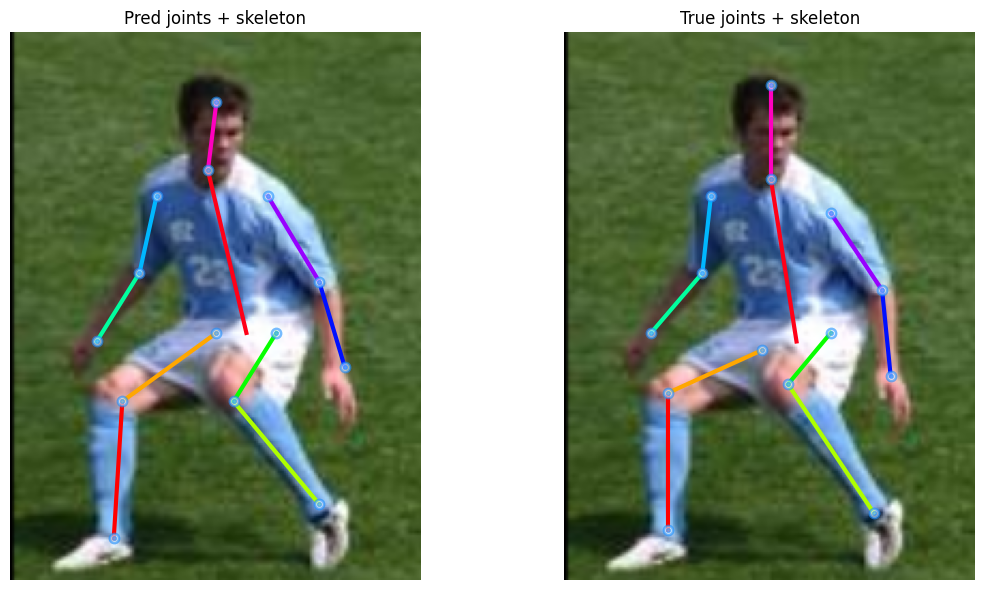

In [ ]:
# stick figure

# fix dimensions
pred_xy_img = pred_xy.clone()
true_xy_img = true_xy.clone()

pred_xy_img[:,:,0] *= 192/48
pred_xy_img[:,:,1] *= 256/64
true_xy_img[:,:,0] *= 192/48
true_xy_img[:,:,1] *= 256/64

pred_parts_xy = joints_to_parts(pred_xy)
true_parts_xy = joints_to_parts(true_xy)

pred_parts_xy_img = pred_parts_xy.clone()
true_parts_xy_img = true_parts_xy.clone()

pred_parts_xy_img[..., 0] *= 192/48
pred_parts_xy_img[..., 1] *= 256/64
true_parts_xy_img[..., 0] *= 192/48
true_parts_xy_img[..., 1] *= 256/64

idx = 100
# visualize some test images
im, ht, _ = test_dataset[idx]

# permute to get right img coordinates
im = im.permute(1, 2, 0)

P = pred_parts_xy_img.shape[1]
cmap = plt.get_cmap("hsv", P)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# left: pred
ax[0].imshow(im)
segs = pred_parts_xy_img[idx].cpu().numpy()
for i in range(P):
    (x1, y1), (x2, y2) = segs[i]
    ax[0].plot([x1, x2], [y1, y2], linewidth=3, color=cmap(i), zorder=2)

x = pred_xy_img[idx, :, 0].cpu().numpy()
y = pred_xy_img[idx, :, 1].cpu().numpy()
ax[0].scatter(x, y, s=45, facecolors="white",
             edgecolors="dodgerblue", linewidths=1.8, alpha=0.6, zorder=3)
ax[0].scatter(x, y, s=8, c="dodgerblue", alpha=0.5, zorder=4)

ax[0].set_title("Pred joints + skeleton")
ax[0].axis("off")

# right: true
ax[1].imshow(im)

segs = true_parts_xy_img[idx].cpu().numpy()
for i in range(P):
    (x1, y1), (x2, y2) = segs[i]
    ax[1].plot([x1, x2], [y1, y2], linewidth=3, color=cmap(i), zorder=2)

x = true_xy_img[idx, :, 0].cpu().numpy()
y = true_xy_img[idx, :, 1].cpu().numpy()
ax[1].scatter(x, y, s=45, facecolors="white",
             edgecolors="dodgerblue", linewidths=1.8, alpha=0.6, zorder=3)
ax[1].scatter(x, y, s=8, c="dodgerblue", alpha=0.5, zorder=4)

ax[1].set_title("True joints + skeleton")
ax[1].axis("off")

plt.tight_layout()
plt.show()

We visualize pose estimation of all images in the test set and compare them to ground-truth.

In [ ]:
# 2 minutes

pred_xy_img = pred_xy.clone()
true_xy_img = true_xy.clone()

pred_xy_img[:,:,0] *= 192/48
pred_xy_img[:,:,1] *= 256/64
true_xy_img[:,:,0] *= 192/48
true_xy_img[:,:,1] *= 256/64

pred_parts_xy = joints_to_parts(pred_xy)
true_parts_xy = joints_to_parts(true_xy)

pred_parts_xy_img = pred_parts_xy.clone()
true_parts_xy_img = true_parts_xy.clone()

pred_parts_xy_img[..., 0] *= 192/48
pred_parts_xy_img[..., 1] *= 256/64
true_parts_xy_img[..., 0] *= 192/48
true_parts_xy_img[..., 1] *= 256/64

idxs = range(len(test_dataset)) # 400 images
for idx in idxs:
    # visualize some test images
    im, ht, _ = test_dataset[idx]

    # permute to get right coordinates
    im = im.permute(1, 2, 0)

    P = pred_parts_xy_img.shape[1]
    cmap = plt.get_cmap("hsv", P)



    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # left: pred
    ax[0].imshow(im)
    segs = pred_parts_xy_img[idx].cpu().numpy()
    for i in range(P):
        (x1, y1), (x2, y2) = segs[i]
        ax[0].plot([x1, x2], [y1, y2], linewidth=3, color=cmap(i), zorder=2)

    x = pred_xy_img[idx, :, 0].cpu().numpy()
    y = pred_xy_img[idx, :, 1].cpu().numpy()
    ax[0].scatter(x, y, s=45, facecolors="white",
                edgecolors="dodgerblue", linewidths=1.8, alpha=0.6, zorder=3)
    ax[0].scatter(x, y, s=8, c="dodgerblue", alpha=0.5, zorder=4)

    ax[0].set_title("Pred joints + skeleton")
    ax[0].axis("off")

    # right: true
    ax[1].imshow(im)

    segs = true_parts_xy_img[idx].cpu().numpy()
    for i in range(P):
        (x1, y1), (x2, y2) = segs[i]
        ax[1].plot([x1, x2], [y1, y2], linewidth=3, color=cmap(i), zorder=2)

    x = true_xy_img[idx, :, 0].cpu().numpy()
    y = true_xy_img[idx, :, 1].cpu().numpy()
    ax[1].scatter(x, y, s=45, facecolors="white",
                edgecolors="dodgerblue", linewidths=1.8, alpha=0.6, zorder=3)
    ax[1].scatter(x, y, s=8, c="dodgerblue", alpha=0.5, zorder=4)

    ax[1].set_title("True joints + skeleton")
    ax[1].axis("off")

    plt.tight_layout()
    plt.show()

# Action Classification Pipeline:

Since our dataset didn't include ground-truth image action labels, we considered first an unsupervised learning approach. As a second approach, we manually labeled the images to perform supervised learning.

## Unsupervised Approach

**KMeans**

We start from ground-truth joints in crop coordinates and build a compact feature vector designed to capture “action” rather than absolute position.

We first normalize the skeleton (center at hips midpoint and scale by neck–hips distance) to remove translation and scale effects.

To select the best number of clusters K and feature vector representation, we implemented a Grid Search where we fit the models on the Training Set and evaluate the quality of the clusters on the Validation Set.

The metrics we took into consideration are ARI (Adjusted Rand Score, to evaluate cluster stability across different seeds) and Silhouette score (to check cluster separability).

We considered values of K in the range between 2 and 10 and three different feature representations: one (A) designed to emphasize jump-like actions, one (B) based on the main angles betwee body parts, one (C) as a concatenation of the first two

### Build feature representations Grid Search function

Feature Representations:

In [ ]:
# joint index
R_ANK, R_KNE, R_HIP = 0, 1, 2
L_HIP, L_KNE, L_ANK = 3, 4, 5
R_WRIST, R_ELB, R_SHO = 6, 7, 8
L_SHO, L_ELB, L_WRIST = 9, 10, 11
NECK = 12

def normalize_np(joints_crop):
    """normalizes pose"""
    hip_mid = 0.5 * (joints_crop[:, R_HIP] + joints_crop[:, L_HIP])
    j0 = joints_crop - hip_mid[:, None, :]
    scale = np.linalg.norm(joints_crop[:, NECK] - hip_mid, axis=1)
    scale = np.clip(scale, 1.0, None)
    return j0 / scale[:, None, None]

def angle_np(a, b, c):
    """ computes angles between body parts """
    ba = a - b
    bc = c - b
    denom = (np.linalg.norm(ba, axis=1) * np.linalg.norm(bc, axis=1))
    denom = np.clip(denom, 1e-6, None)
    cosang = np.sum(ba * bc, axis=1) / denom
    cosang = np.clip(cosang, -1.0, 1.0)
    return np.arccos(cosang)

# three vector feature representations: A jump based, B angle based, C both

def build_action_features_A(joints_crop):
    """ considers knee bend angles, feet separation, avg foot height,
        inversion, "stretch" (body elongation)
     """
    jn = normalize_np(joints_crop)

    idx = [R_ANK, R_KNE, R_HIP, L_HIP, L_KNE, L_ANK, NECK]
    coords = jn[:, idx, :].reshape(jn.shape[0], -1)
    # knee angles
    ang_rk = angle_np(jn[:, R_ANK], jn[:, R_KNE], jn[:, R_HIP])
    ang_lk = angle_np(jn[:, L_ANK], jn[:, L_KNE], jn[:, L_HIP])
    # feet separation
    dist_ank = np.linalg.norm(jn[:, R_ANK] - jn[:, L_ANK], axis=1)
    mean_ank_y = 0.5 * (jn[:, R_ANK, 1] + jn[:, L_ANK, 1])

    hip_mid = 0.5 * (jn[:, R_HIP] + jn[:, L_HIP])

    # inversion (neck below hips)
    neck_rel_y = jn[:, NECK, 1] - hip_mid[:, 1]
    inv_flag   = (neck_rel_y > 0).astype(np.float32)
    inv_margin = np.maximum(0.0, neck_rel_y)

    # both feet high relative to hips
    hR = hip_mid[:, 1] - jn[:, R_ANK, 1]
    hL = hip_mid[:, 1] - jn[:, L_ANK, 1]
    both_ank_high = np.minimum(hR, hL)

    # "stretch"
    stretch = 0.5 * (
        np.linalg.norm(jn[:, NECK] - jn[:, R_ANK], axis=1) +
        np.linalg.norm(jn[:, NECK] - jn[:, L_ANK], axis=1)
    )

    # prevent outliers
    both_ank_high_s = np.tanh(both_ank_high)
    inv_margin_s    = np.tanh(inv_margin)
    stretch_s       = np.tanh(stretch)

    jump_score = both_ank_high_s + 0.5 * inv_margin_s + 0.5 * stretch_s

    X = np.concatenate([
        coords,
        ang_rk[:, None], ang_lk[:, None],
        dist_ank[:, None],
        mean_ank_y[:, None],
        inv_flag[:, None],
        jump_score[:, None],
    ], axis=1).astype(np.float32)

    return X


def build_action_features_B(joints_crop):
    """ considers all the main angles (knees, elbows, hips, shoulders) """
    jn = normalize_np(joints_crop)

    idx = [R_ANK, R_KNE, R_HIP, L_HIP, L_KNE, L_ANK, NECK]
    coords = jn[:, idx, :].reshape(jn.shape[0], -1)
    # knees
    ang_rk = angle_np(jn[:, R_ANK], jn[:, R_KNE], jn[:, R_HIP])
    ang_lk = angle_np(jn[:, L_ANK], jn[:, L_KNE], jn[:, L_HIP])

    # elbows
    ang_re = angle_np(jn[:, R_WRIST], jn[:, R_ELB], jn[:, R_SHO])
    ang_le = angle_np(jn[:, L_WRIST], jn[:, L_ELB], jn[:, L_SHO])

    # hips (knee - hip - neck)
    ang_rhip = angle_np(jn[:, R_KNE], jn[:, R_HIP], jn[:, NECK])
    ang_lhip = angle_np(jn[:, L_KNE], jn[:, L_HIP], jn[:, NECK])

    # shoulders (elbow - shoulder - neck)
    ang_rsho = angle_np(jn[:, R_ELB], jn[:, R_SHO], jn[:, NECK])
    ang_lsho = angle_np(jn[:, L_ELB], jn[:, L_SHO], jn[:, NECK])

    angles = np.stack(
        [ang_rk, ang_lk, ang_re, ang_le, ang_rhip, ang_lhip, ang_rsho, ang_lsho],
        axis=1
    ).astype(np.float32)

    X = np.concatenate([coords, angles], axis=1).astype(np.float32)

    return X


def build_action_features_C(joints_crop):
    """ combination of A and B """
    jn = normalize_np(joints_crop)

    idx = [R_ANK, R_KNE, R_HIP, L_HIP, L_KNE, L_ANK, NECK]
    coords = jn[:, idx, :].reshape(jn.shape[0], -1)

    ang_rk = angle_np(jn[:, R_ANK],  jn[:, R_KNE], jn[:, R_HIP])
    ang_lk = angle_np(jn[:, L_ANK],  jn[:, L_KNE], jn[:, L_HIP])
    ang_re = angle_np(jn[:, R_WRIST], jn[:, R_ELB], jn[:, R_SHO])
    ang_le = angle_np(jn[:, L_WRIST], jn[:, L_ELB], jn[:, L_SHO])
    ang_rhip = angle_np(jn[:, R_KNE], jn[:, R_HIP], jn[:, NECK])
    ang_lhip = angle_np(jn[:, L_KNE], jn[:, L_HIP], jn[:, NECK])
    ang_rsho = angle_np(jn[:, R_ELB], jn[:, R_SHO], jn[:, NECK])
    ang_lsho = angle_np(jn[:, L_ELB], jn[:, L_SHO], jn[:, NECK])

    angles = np.stack(
        [ang_rk, ang_lk, ang_re, ang_le, ang_rhip, ang_lhip, ang_rsho, ang_lsho],
        axis=1
    ).astype(np.float32)

    dist_ank = np.linalg.norm(jn[:, R_ANK] - jn[:, L_ANK], axis=1)
    mean_ank_y = 0.5 * (jn[:, R_ANK, 1] + jn[:, L_ANK, 1])

    hip_mid = 0.5 * (jn[:, R_HIP] + jn[:, L_HIP])

    # inversion: neck below hips
    neck_rel_y = jn[:, NECK, 1] - hip_mid[:, 1]
    inv_flag   = (neck_rel_y > 0).astype(np.float32)
    inv_margin = np.maximum(0.0, neck_rel_y)

    # both feet high relative to hips
    hR = hip_mid[:, 1] - jn[:, R_ANK, 1]
    hL = hip_mid[:, 1] - jn[:, L_ANK, 1]
    both_ank_high = np.minimum(hR, hL)

    # “stretch”
    stretch = 0.5 * (
        np.linalg.norm(jn[:, NECK] - jn[:, R_ANK], axis=1) +
        np.linalg.norm(jn[:, NECK] - jn[:, L_ANK], axis=1)
    )

    # prevent outliers
    both_ank_high_s = np.tanh(both_ank_high)
    inv_margin_s    = np.tanh(inv_margin)
    stretch_s       = np.tanh(stretch)

    jump_score = both_ank_high_s + 0.5 * inv_margin_s + 0.5 * stretch_s

    X = np.concatenate([
        coords,
        angles,
        dist_ank[:, None],
        mean_ank_y[:, None],
        inv_flag[:, None],
        jump_score[:, None],
    ], axis=1).astype(np.float32)

    return X

Grid Search

In [ ]:
def cluster_size_stats(labels, K):
    labels = np.asarray(labels)
    counts = np.bincount(labels, minlength=K)
    N = counts.sum()
    p = counts / max(N, 1)

    largest_frac = counts.max() / max(N, 1)
    eps = 1e-12
    H = -(p * np.log(p + eps)).sum()
    H_norm = H / np.log(K) if K > 1 else 0.0

    return {
        "counts": counts,
        "largest_frac": float(largest_frac),
        "min": int(counts.min()),
        "max": int(counts.max()),
        "median": float(np.median(counts)),
    }


def run_gridsearch(alg,joints_crop, feature_builders, K_values, seeds):

  results = []
  stability = []

  for fb in feature_builders:

    X_all = fb(joints_crop)
    X_train = X_all[train_idx]
    X_val   = X_all[val_idx]

    method_name = getattr(fb, "__name__", str(fb))

    for K in K_values:
      val_labels_by_seed = []

      for s in seeds:
        model = alg(K, random_state = int(s))
        model.fit(X_train)
        val_labels = model.predict(X_val).astype(np.int64)
        val_labels_by_seed.append(val_labels)

        # metrics computed on VAL
        # (silhouette requires >=2 clusters present in val labels)
        sil = np.nan
        if len(np.unique(val_labels)) > 1 and X_val.shape[0] > K:
            sil = float(silhouette_score(X_val, val_labels))

        size = cluster_size_stats(val_labels, K)

        results.append({
            "method" : method_name,
            "K" : int(K),
            "seed" : int(s),
            "silhouette" : float(sil),
            "largest_frac": size["largest_frac"],
            "min_cluster": size["min"],
            "median_cluster": size["median"],
            "max_cluster": size["max"],
        })

      # stability across seeds

      ari =  []
      for i in range(len(val_labels_by_seed)):
        for j in range(i+1, len(val_labels_by_seed)):
          ari.append(adjusted_rand_score(val_labels_by_seed[i], val_labels_by_seed[j]))

      stability.append({
          "method": method_name,
          "K": int(K),
          "ARI_mean": float(np.mean(ari)),
          "ARI_std": float(np.std(ari)),
      })

  return results, stability

In [ ]:
par_dict  = {"methods" : [build_action_features_A, build_action_features_B, build_action_features_C],
              "K" : range(2,11),
              "seeds" : range(10),
              }

results, stability = run_gridsearch(KMeans, joints_crop_all, feature_builders = par_dict["methods"], K_values = par_dict["K"], seeds = par_dict["seeds"] )

In [ ]:
def summarize(results, stability):
    w = 10
    stab = {}
    for s in stability:
        stab[(s["method"], s["K"])] = (s["ARI_mean"], s["ARI_std"])

    agg = {}

    for r in results:
        key = (r["method"], r["K"])
        if key not in agg:
            agg[key] = {"silhouette": [], "largest_frac": []}
        agg[key]["silhouette"].append(r["silhouette"])
        agg[key]["largest_frac"].append(r["largest_frac"])

    # build summary rows
    rows = []
    for key, d in agg.items():
        m, K = key
        sil = float(np.mean(d["silhouette"]))
        lf  = float(np.mean(d["largest_frac"]))
        ari_mean, ari_std = stab.get(key, (np.nan, np.nan))
        rows.append((m, K, ari_mean, ari_std, sil, lf))

    # print grouped by method
    methods = sorted(set(m for (m, _, _, _, _, _) in rows))
    for m in methods:
        print("\n" + "="*70)
        print(f"Method: {m}")
        print(f"{'K':^{w}} | {'ARI(mean±std)':^{2*w}} | {'sil':^{w}} | {'largest%':^{w}} ")
        print("-"*70)

        sub = [r for r in rows if r[0] == m]
        sub.sort(key=lambda x: (x[2], x[4]), reverse=True)  # ARI then sil

        for (_, K, ari_m, ari_s, sil, lf) in sub:
            print(f"{K:^{w}} | {ari_m:^{w}.3f}±{ari_s:^{w}.3f} | {sil:^{w}.3f} | {100*lf:^{w}.3f}% ")


summarize(results, stability)



Method: build_action_features_A
    K      |    ARI(mean±std)     |    sil     |  largest%  
----------------------------------------------------------------------
    2      |   1.000   ±  0.000    |   0.535    |   91.500  % 
    9      |   0.844   ±  0.065    |   0.226    |   45.150  % 
    10     |   0.825   ±  0.078    |   0.224    |   44.250  % 
    8      |   0.779   ±  0.110    |   0.224    |   45.950  % 
    7      |   0.774   ±  0.117    |   0.235    |   49.550  % 
    3      |   0.734   ±  0.337    |   0.331    |   69.600  % 
    6      |   0.626   ±  0.206    |   0.231    |   50.200  % 
    5      |   0.582   ±  0.214    |   0.217    |   50.850  % 
    4      |   0.520   ±  0.287    |   0.283    |   59.150  % 

Method: build_action_features_B
    K      |    ARI(mean±std)     |    sil     |  largest%  
----------------------------------------------------------------------
    2      |   1.000   ±  0.000    |   0.341    |   83.500  % 
    3      |   0.962   ±  0.027    |   0

### Select best configuration

The best configuration appears to be K=3 using feature vector representation (A). We fit this model on the Training Set and predict the labels for all the data, to obtain the *pseudo-labels* for the rest of our analisys

In [ ]:
K = 3

X_all = build_action_features_A(joints_crop_all)
X_train = X_all[train_idx]

#KMeans
km = KMeans(n_clusters = K, random_state = 44)
km.fit(X_train)
cluster_all = km.predict(X_all).astype(np.int64)

action_labels = cluster_all

# counts per class
counts = np.bincount(action_labels)
print("Action counts:", counts)

# inverse frequency weighting
weights = 1.0 / counts
weights = weights / weights.sum() * len(counts)

class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

print("Class weights:", class_weights)
print("Train counts:", np.bincount(action_labels[train_idx]))
print("Val counts:",   np.bincount(action_labels[val_idx]))
print("Test counts:",  np.bincount(action_labels[test_idx]))

Action counts: [1399  110  491]
Class weights: tensor([0.1811, 2.3030, 0.5159], device='cuda:0')
Train counts: [998  74 328]
Val counts: [133  10  57]
Test counts: [268  26 106]


### Visual inspection of clusters:

We sample a few images per cluster and visualize the cropped person and joints.

Cluster 0


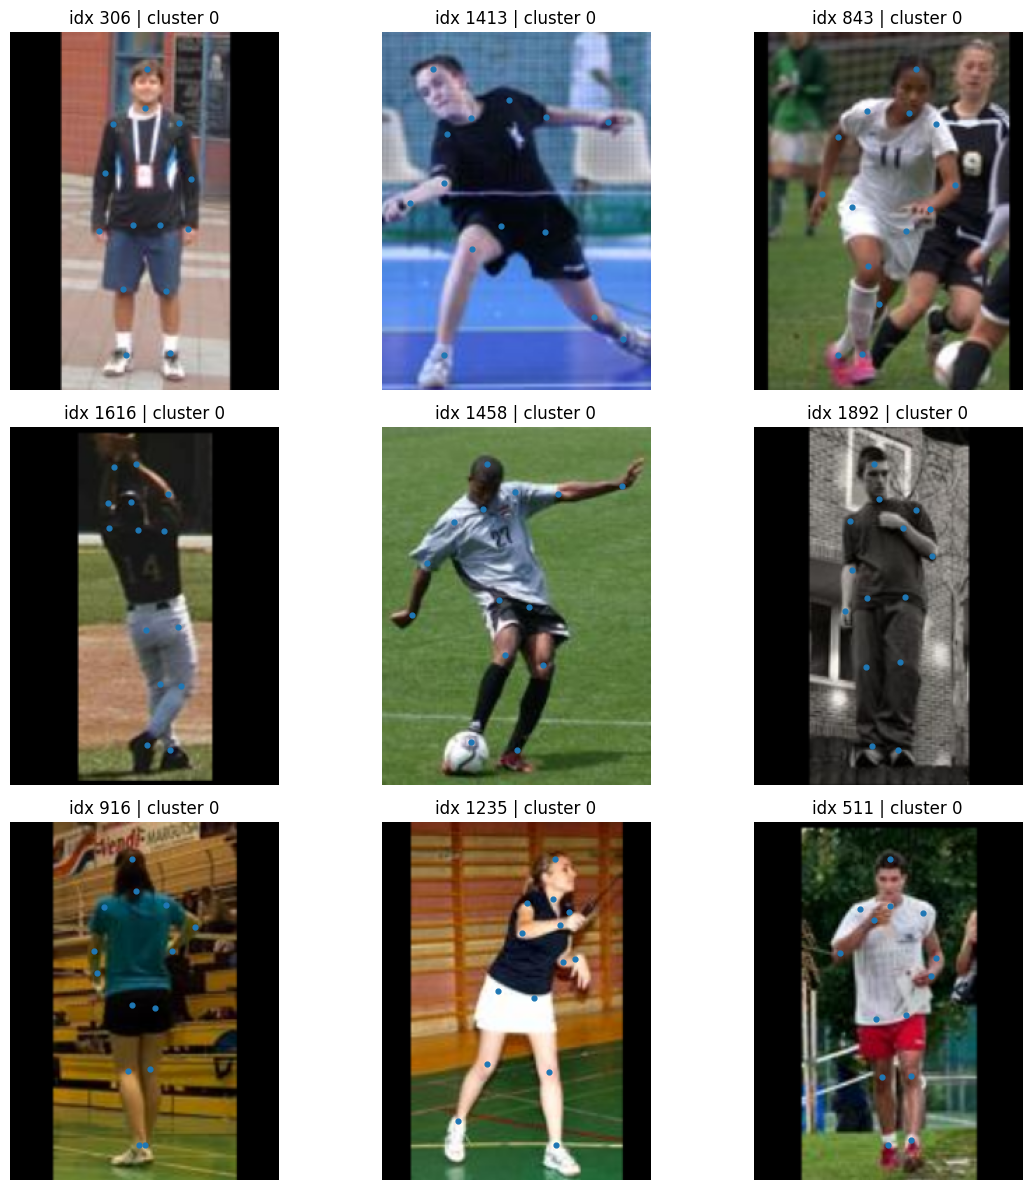

Cluster 1


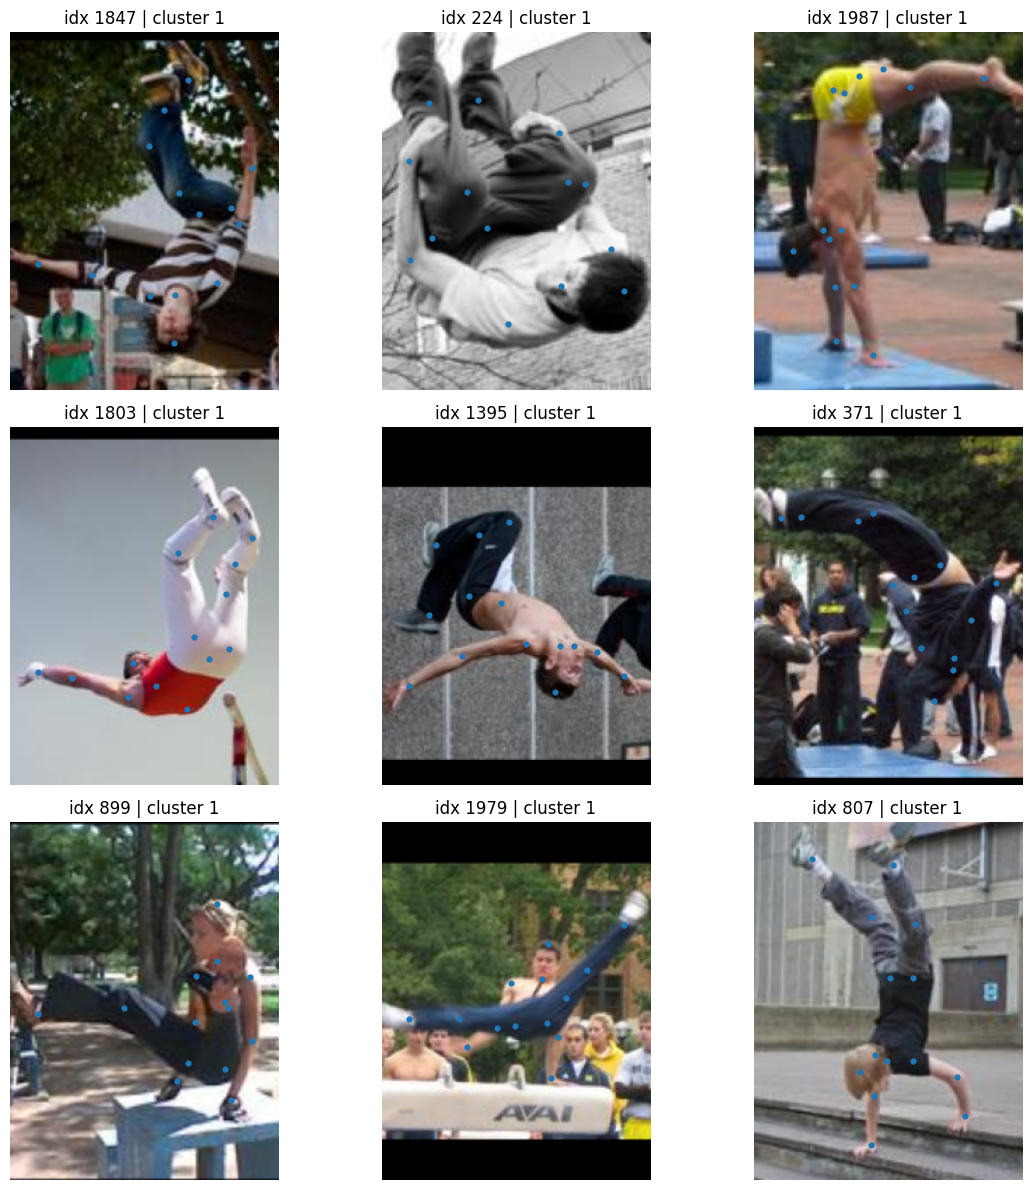

Cluster 2


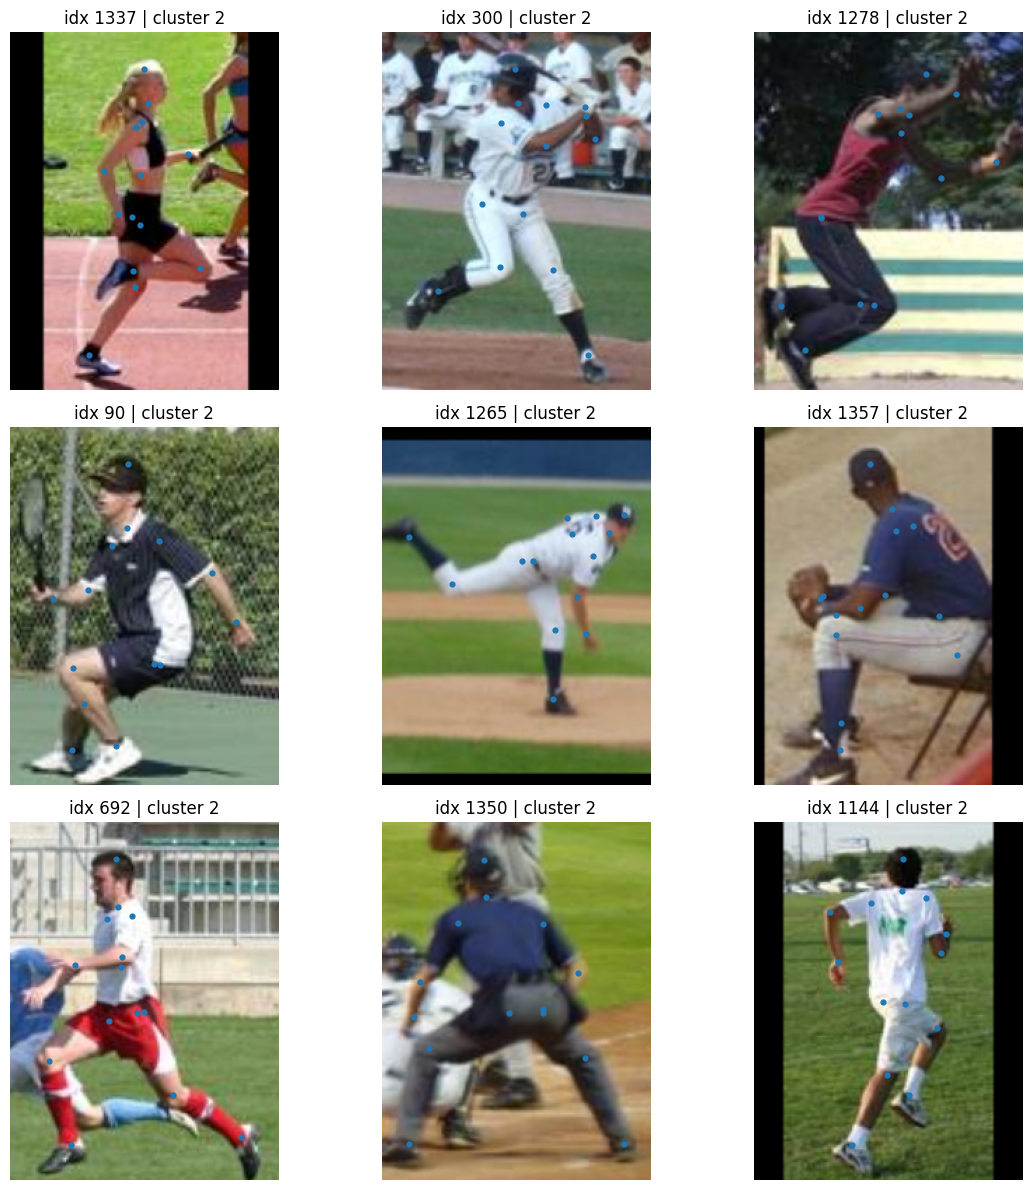

In [ ]:
def show_examples_per_cluster(cluster_labels, cluster_id, n=9):
    idxs = np.where(cluster_labels == cluster_id)[0]
    if len(idxs) == 0:
        print("No samples for cluster", cluster_id)
        return
    pick = np.random.choice(idxs, size=min(n, len(idxs)), replace=False)
    cols = 3
    rows = int(np.ceil(len(pick)/cols))
    plt.figure(figsize=(cols*4, rows*4))
    for t, i in enumerate(pick, 1):
        img_bgr = cv2.imread(image_files[i])
        joints_i = joints[i]
        center, scale = joints_to_center_scale(joints_i, image_size=IMAGE_SIZE)
        trans = get_affine_transform(center, scale, rotation=0, output_size=IMAGE_SIZE)
        crop_bgr = cv2.warpAffine(img_bgr, trans, IMAGE_SIZE, flags=cv2.INTER_LINEAR)
        crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
        xy_crop = joints_crop_all[i]
        plt.subplot(rows, cols, t)
        plt.imshow(crop_rgb)
        plt.scatter(xy_crop[:,0], xy_crop[:,1], s=12)
        plt.title(f"idx {i} | cluster {cluster_id}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

for c in range(K):
    print("Cluster", c)
    show_examples_per_cluster(action_labels, c, n=9)

### Define Classification Models:

Our classification models will take as input the joint coordinates that are output of our Pose Estimation model.

In [ ]:
# best model
best_path = "posenet.pt"

pose_model.load_state_dict(torch.load(best_path, map_location=device))
pose_model.to(device)
pose_model.eval()

ResNetPoseHead(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kern

In [ ]:
# to use saved weights
# POSE_PATH = "/content/checkpoints/checkpoints/posenet.pt"

# pose_model = ResNetPoseHead(backbone, num_joints=14).to(device)
# pose_model.load_state_dict(torch.load(POSE_PATH, map_location=device))
# pose_model.eval()

# for p in pose_model.parameters():
#     p.requires_grad = False

**ActionMLP Model:**

This is the simplest classifier.
It receives normalized joint coordinates and outputs the action class.
It has two hidden layers and dropout for regularization.
This model is our baseline reference.

In [ ]:
class ActionMLP(nn.Module):
    def __init__(self, input_dim=28, output_dim=3, hidden1=128, hidden2=64, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, joints_crop):
        hip_mid = 0.5 * (joints_crop[:,2] + joints_crop[:,3])
        j0 = joints_crop - hip_mid[:, None, :]
        scale = torch.norm(joints_crop[:,12] - hip_mid, dim=1).clamp(min=1.0)
        jn = j0 / scale[:, None, None]

        B = jn.shape[0]
        x = jn.view(B, -1)
        x = self.fc1(x); x = self.relu(x); x = self.dropout(x)
        x = self.fc2(x); x = self.relu(x); x = self.dropout(x)
        y = self.fc3(x)
        return y


**Deep ActionMLP Model:**

Deeper version of our previous MLPs. This model has more layers. We trained this model using only weighted Cross Entropy.

In [ ]:
class ActionMLP_Deep(nn.Module):
    def __init__(self, input_dim=28, output_dim=3,
                 hidden1=256, hidden2=128, hidden3=64,
                 dropout=0.3, use_bn=True):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1) if use_bn else nn.Identity()

        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2) if use_bn else nn.Identity()

        self.fc3 = nn.Linear(hidden2, hidden3)
        self.bn3 = nn.BatchNorm1d(hidden3) if use_bn else nn.Identity()

        self.fc_out = nn.Linear(hidden3, output_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, joints_crop):
        # joints_crop: (B,14,2)

        # normalization
        hip_mid = 0.5 * (joints_crop[:,2] + joints_crop[:,3])   # (B,2)
        j0 = joints_crop - hip_mid[:, None, :]                  # (B,14,2)

        scale = torch.norm(joints_crop[:,12] - hip_mid, dim=1).clamp(min=1.0)
        jn = j0 / scale[:, None, None]                          # (B,14,2)

        B = jn.shape[0]
        x = jn.view(B, -1)                                      # (B,28)

        # block 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # block 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # block 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)

        # output
        y = self.fc_out(x)                        # (B,3)
        return y

**RandomForest Classifier:**

As a non-neural baseline, we implemented a RandomForest model with 600 trees.

We first define a function to extract joints coordinates in shape (B, 2J) from the PoseNet model output.

In [ ]:
@torch.no_grad()
def extract_pose_joints_rf(model_pose, loader, device, action_labels):
    """
    extracts 2D numpy array of shape (B, 2J) from PoseNet model output
    """
    model_pose.eval()
    X_list, y_list = [], []

    for images, _, idx in loader:
        images = images.to(device)
        idx_np = idx.cpu().numpy()


        h_pred = model_pose(images)
        j_pred = heatmaps_to_coords_img(h_pred)   # (B, J, 2)

        # normalize joints like MLP + flatten
        hip_mid = 0.5 * (j_pred[:, 2] + j_pred[:, 3])    # (B,2)
        j0 = j_pred - hip_mid[:, None, :]                # center

        scale = torch.norm(j_pred[:, 12] - hip_mid, dim=1).clamp(min=1.0)  # (B,)
        jn = j0 / scale[:, None, None]                   # (B,J,2)

        Xb = jn.reshape(jn.shape[0], -1).cpu().numpy().astype(np.float32)  # flatten (B, 2J)                     # (B, D)

        # labels from clustering
        yb = action_labels[idx_np].astype(np.int64)             # (B,)

        X_list.append(Xb)
        y_list.append(yb)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    return X, y

def heatmaps_to_coords_img(hm, image_size=(192,256), heatmap_size=(48,64)):
    B, J, Hm, Wm = hm.shape
    flat = hm.view(B, J, -1)
    idx = flat.argmax(dim=2)

    y = idx // Wm
    x = idx % Wm
    xy = torch.stack([x, y], dim=2).float()

    xy[:,:,0] *= image_size[0] / heatmap_size[0]
    xy[:,:,1] *= image_size[1] / heatmap_size[1]
    return xy


# convert weights to dict
w = torch.tensor([0.1811, 2.3030, 0.5159]).cpu().numpy()
class_weight_rf = {0: float(w[0]), 1: float(w[1]), 2: float(w[2])}

In [ ]:
# Extract features
X_train, y_train = extract_pose_joints_rf(pose_model, train_iterator, device, action_labels)
X_val,   y_val   = extract_pose_joints_rf(pose_model, val_iterator,   device, action_labels)

print("Shapes:", X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print("Train counts:", np.bincount(y_train))
print("Val counts:", np.bincount(y_val))

# Fit RF
rf = RandomForestClassifier(
    n_estimators=600,
    min_samples_leaf=2,
    random_state=44,
    n_jobs=-1,
    class_weight=class_weight_rf
)

Shapes: (1400, 28) (1400,) (200, 28) (200,)
Train counts: [998  74 328]
Val counts: [133  10  57]


We define training and evaluation functions

In [ ]:
def calculate_accuracy(y_pred, y):
    y_hat = y_pred.argmax(dim=1)
    return (y_hat == y).float().mean()

def train_action(model_pose, model_action, iterator, optimizer, criterion, device, action_labels):
    epoch_loss, epoch_acc = 0.0, 0.0

    model_action.train()
    model_pose.eval()

    for images, _, idx in iterator:
        images = images.to(device)
        idx_np = idx.cpu().numpy()
        y = torch.tensor(action_labels[idx_np], dtype=torch.long, device=device)

        optimizer.zero_grad()

        with torch.no_grad():
            h_pred = model_pose(images)
            j_pred = heatmaps_to_coords_img(h_pred)

        y_pred = model_action(j_pred)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss/len(iterator), epoch_acc/len(iterator)

@torch.no_grad()
def evaluate_action(model_pose, model_action, iterator, criterion, device, action_labels):
    epoch_loss, epoch_acc = 0.0, 0.0

    model_action.eval()
    model_pose.eval()

    for images, _, idx in iterator:
        images = images.to(device)
        idx_np = idx.cpu().numpy()
        y = torch.tensor(action_labels[idx_np], dtype=torch.long, device=device)

        h_pred = model_pose(images)
        j_pred = heatmaps_to_coords_img(h_pred)
        y_pred = model_action(j_pred)

        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss/len(iterator), epoch_acc/len(iterator)

def model_training_action(n_epochs,
                          model_pose,
                          model_action,
                          train_iterator,
                          val_iterator,
                          optimizer,
                          criterion,
                          device,
                          action_labels,
                          model_name='action_mlp.pt'):

    best_valid_loss = float("inf")
    train_losses, train_accs = [], []
    valid_losses, valid_accs = [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_action(
            model_pose, model_action, train_iterator,
            optimizer, criterion, device, action_labels
        )

        valid_loss, valid_acc = evaluate_action(
            model_pose, model_action, val_iterator,
            criterion, device, action_labels
        )

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_action.state_dict(), model_name)

        print(f"Epoch {epoch+1}/{n_epochs} | "
              f"Train Loss {train_loss:.3f} Acc {train_acc*100:.2f}% | "
              f"Val Loss {valid_loss:.3f} Acc {valid_acc*100:.2f}%")

        train_losses.append(train_loss); train_accs.append(train_acc)
        valid_losses.append(valid_loss); valid_accs.append(valid_acc)

    return train_losses, train_accs, valid_losses, valid_accs

### Models Training:

For the Standard MLP, we train two models: one using normal Cross Entropy loss function and one using Weighted Cross Entropy, to account for unbalanced classes.

**ActionMLP training with normal Cross Entropy**

In [ ]:
# train model
ce_normal = nn.CrossEntropyLoss()

action_model_base = ActionMLP().to(device)
opt_base = optim.Adam(action_model_base.parameters(), lr=1e-3)

train_losses_b, train_accs_b, valid_losses_b, valid_accs_b = model_training_action(
    20, pose_model, action_model_base, train_iterator, val_iterator,
    opt_base, ce_normal, device, action_labels,
    model_name="action_mlp_base_normal.pt"
)

Epoch 1/20 | Train Loss 0.905 Acc 63.67% | Val Loss 0.697 Acc 72.27%
Epoch 2/20 | Train Loss 0.664 Acc 73.80% | Val Loss 0.603 Acc 73.05%
Epoch 3/20 | Train Loss 0.571 Acc 75.44% | Val Loss 0.592 Acc 73.44%
Epoch 4/20 | Train Loss 0.533 Acc 76.49% | Val Loss 0.564 Acc 74.61%
Epoch 5/20 | Train Loss 0.521 Acc 76.68% | Val Loss 0.541 Acc 75.39%
Epoch 6/20 | Train Loss 0.491 Acc 78.18% | Val Loss 0.536 Acc 75.78%
Epoch 7/20 | Train Loss 0.478 Acc 79.16% | Val Loss 0.545 Acc 76.56%
Epoch 8/20 | Train Loss 0.465 Acc 80.80% | Val Loss 0.503 Acc 77.34%
Epoch 9/20 | Train Loss 0.449 Acc 80.66% | Val Loss 0.479 Acc 78.52%
Epoch 10/20 | Train Loss 0.452 Acc 82.25% | Val Loss 0.484 Acc 79.30%
Epoch 11/20 | Train Loss 0.442 Acc 82.65% | Val Loss 0.447 Acc 79.30%
Epoch 12/20 | Train Loss 0.421 Acc 82.86% | Val Loss 0.442 Acc 80.47%
Epoch 13/20 | Train Loss 0.438 Acc 82.01% | Val Loss 0.447 Acc 79.30%
Epoch 14/20 | Train Loss 0.421 Acc 82.35% | Val Loss 0.487 Acc 79.30%
Epoch 15/20 | Train Loss 0.42

**ActionMLP training with weighted Cross Entropy**

In [ ]:
ce_weighted = nn.CrossEntropyLoss(weight=class_weights)

action_model_base_w = ActionMLP().to(device)
opt_base_w = optim.Adam(action_model_base_w.parameters(), lr=1e-3)

train_losses_bw, train_accs_bw, valid_losses_bw, valid_accs_bw = model_training_action(
    20, pose_model, action_model_base_w, train_iterator, val_iterator,
    opt_base_w, ce_weighted, device, action_labels,
    model_name="action_mlp_base_weighted.pt"
)

Epoch 1/20 | Train Loss 1.019 Acc 64.95% | Val Loss 0.893 Acc 75.39%
Epoch 2/20 | Train Loss 0.769 Acc 73.58% | Val Loss 0.666 Acc 76.95%
Epoch 3/20 | Train Loss 0.596 Acc 70.43% | Val Loss 0.596 Acc 77.73%
Epoch 4/20 | Train Loss 0.575 Acc 73.97% | Val Loss 0.585 Acc 77.73%
Epoch 5/20 | Train Loss 0.518 Acc 75.58% | Val Loss 0.541 Acc 79.30%
Epoch 6/20 | Train Loss 0.582 Acc 72.76% | Val Loss 0.516 Acc 81.25%
Epoch 7/20 | Train Loss 0.523 Acc 76.97% | Val Loss 0.511 Acc 80.47%
Epoch 8/20 | Train Loss 0.757 Acc 77.51% | Val Loss 0.515 Acc 81.25%
Epoch 9/20 | Train Loss 0.499 Acc 77.42% | Val Loss 0.528 Acc 81.25%
Epoch 10/20 | Train Loss 0.495 Acc 77.63% | Val Loss 0.536 Acc 81.25%
Epoch 11/20 | Train Loss 0.493 Acc 79.15% | Val Loss 0.527 Acc 80.47%
Epoch 12/20 | Train Loss 0.503 Acc 75.65% | Val Loss 0.540 Acc 80.08%
Epoch 13/20 | Train Loss 0.472 Acc 77.81% | Val Loss 0.491 Acc 80.47%
Epoch 14/20 | Train Loss 0.442 Acc 78.57% | Val Loss 0.505 Acc 81.25%
Epoch 15/20 | Train Loss 0.44

**Deep ActionMLP training with weighted Cross Entropy**

In [ ]:
action_model_deep = ActionMLP_Deep().to(device)
opt_deep = optim.Adam(action_model_deep.parameters(), lr=1e-3)

train_losses_d, train_accs_d, valid_losses_d, valid_accs_d = model_training_action(
    20, pose_model, action_model_deep, train_iterator, val_iterator,
    opt_deep, ce_weighted, device, action_labels,
    model_name="action_mlp_deep_weighted.pt"
)

Epoch 1/20 | Train Loss 0.887 Acc 45.92% | Val Loss 0.830 Acc 75.78%
Epoch 2/20 | Train Loss 0.728 Acc 64.64% | Val Loss 0.701 Acc 80.86%
Epoch 3/20 | Train Loss 0.657 Acc 70.04% | Val Loss 0.644 Acc 79.30%
Epoch 4/20 | Train Loss 0.574 Acc 73.22% | Val Loss 0.575 Acc 80.86%
Epoch 5/20 | Train Loss 0.582 Acc 75.39% | Val Loss 0.528 Acc 82.03%
Epoch 6/20 | Train Loss 0.516 Acc 77.66% | Val Loss 0.510 Acc 80.86%
Epoch 7/20 | Train Loss 0.484 Acc 77.52% | Val Loss 0.504 Acc 80.86%
Epoch 8/20 | Train Loss 0.521 Acc 76.50% | Val Loss 0.523 Acc 81.25%
Epoch 9/20 | Train Loss 0.520 Acc 75.17% | Val Loss 0.550 Acc 81.64%
Epoch 10/20 | Train Loss 0.486 Acc 77.98% | Val Loss 0.490 Acc 81.25%
Epoch 11/20 | Train Loss 0.533 Acc 75.37% | Val Loss 0.550 Acc 80.86%
Epoch 12/20 | Train Loss 0.494 Acc 76.00% | Val Loss 0.554 Acc 80.86%
Epoch 13/20 | Train Loss 0.486 Acc 77.16% | Val Loss 0.476 Acc 83.20%
Epoch 14/20 | Train Loss 0.530 Acc 77.17% | Val Loss 0.533 Acc 82.03%
Epoch 15/20 | Train Loss 0.51

**RandomForest Classifier**

In [ ]:
# fit the model
rf.fit(X_train, y_train)

# Evaluate on validation set
pred_val = rf.predict(X_val)

print("VAL acc:", accuracy_score(y_val, pred_val))
print("VAL macro-F1:", f1_score(y_val, pred_val, average="macro"))
print("VAL confusion:\n", confusion_matrix(y_val, pred_val))
print("\nVAL report:\n", classification_report(y_val, pred_val))

VAL acc: 0.815
VAL macro-F1: 0.7998773617129853
VAL confusion:
 [[129   0   4]
 [  0   9   1]
 [ 32   0  25]]

VAL report:
               precision    recall  f1-score   support

           0       0.80      0.97      0.88       133
           1       1.00      0.90      0.95        10
           2       0.83      0.44      0.57        57

    accuracy                           0.81       200
   macro avg       0.88      0.77      0.80       200
weighted avg       0.82      0.81      0.79       200



### Evaluation on the Test Set:

We collect predictions, compute confusion matrices, compute per-class error rates and f1 scores and compare each method graphically.

In [ ]:
@torch.no_grad()
def collect_preds(model_pose, model_action, iterator, device, action_labels, rf = False):
    """ collects class predictions for all models (with rf = True works for RandomForest)"""
    model_pose.eval()
    if rf == False:
      model_action.eval()

    y_true_all, y_pred_all = [], []

    for images, _, idx in iterator:
        images = images.to(device)
        idx_np = idx.cpu().numpy()

        y_true = action_labels[idx_np]

        h_pred = model_pose(images)
        j_pred = heatmaps_to_coords_img(h_pred)

        if rf == False:
            logits = model_action(j_pred)
            y_pred = logits.argmax(dim=1).cpu().numpy()
        if rf == True:
          # joints -> normalized + flattened features (B, 2*J)
          hip_mid = 0.5 * (j_pred[:, 2] + j_pred[:, 3])                 # (B,2)
          j0 = j_pred - hip_mid[:, None, :]                             # (B,J,2)
          scale = torch.norm(j_pred[:, 12] - hip_mid, dim=1).clamp(min=1.0)  # (B,)
          jn = j0 / scale[:, None, None]                                # (B,J,2)
          Xb = jn.reshape(jn.shape[0], -1).cpu().numpy().astype(np.float32)  # (B, 2*J)

          # RF prediction
          y_pred = model_action.predict(Xb).astype(np.int64)

        y_true_all.append(y_true)
        y_pred_all.append(y_pred)

    return np.concatenate(y_true_all), np.concatenate(y_pred_all)

In [ ]:
@torch.no_grad()
def count_predictions(model_pose, model_action, iterator, device, rf=False):
    """counts all classes predictions (with rf = True works for RandomForest)"""
    model_pose.eval()
    if not rf:
        model_action.eval()

    all_preds = []

    for images, _, _ in iterator:
        images = images.to(device)

        h_pred = model_pose(images)
        j_pred = heatmaps_to_coords_img(h_pred)  # torch (B,J,2)

        if not rf:
            logits = model_action(j_pred)        # torch (B,C)
            y_hat = logits.argmax(dim=1).cpu().numpy().astype(np.int64)
        else:
            hip_mid = 0.5 * (j_pred[:, 2] + j_pred[:, 3])
            j0 = j_pred - hip_mid[:, None, :]
            scale = torch.norm(j_pred[:, 12] - hip_mid, dim=1).clamp(min=1.0)
            jn = j0 / scale[:, None, None]
            Xb = jn.reshape(jn.shape[0], -1).cpu().numpy().astype(np.float32)

            y_hat = model_action.predict(Xb).astype(np.int64)

        all_preds.append(y_hat)

    all_preds = np.concatenate(all_preds)
    return np.bincount(all_preds, minlength=3)


In [ ]:
def print_minimal_report(y_true, y_pred, class_names=("0","1","2"), title="MODEL"):
    print("\n====================")
    print(title)
    print("====================")

    if len(class_names) == 3:
      cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    if len(class_names) == 4:
      cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3])

    header = "true\\pred | " + " | ".join([f"{c:>6}" for c in class_names])
    print(header)
    print("-" * len(header))
    for i, c in enumerate(class_names):
        row = " | ".join([f"{cm[i,j]:6d}" for j in range(len(class_names))])
        print(f"{c:>9} | {row}")

    recalls = cm.diagonal() / cm.sum(axis=1).clip(min=1)
    err = 1.0 - recalls
    tp = cm.diagonal().astype(float)
    pred_count = cm.sum(axis=0).astype(float)  # predicted per class
    precision = tp / pred_count.clip(min=1)
    f1 = 2 * precision * recalls / (precision + recalls).clip(min=1e-12)

    print("\nPer-class error rate (1 - recall):")
    for i, c in enumerate(class_names):
        print(f"  Class {c}: {err[i]*100:.2f}%")
    print("\nPer-class F1 score:")
    for i, c in enumerate(class_names):
        print(f"  Class {c}: {f1[i]:.3f}")
    return cm, err, f1

In [ ]:
def plot_error_comparison(err_dict, class_names=("0","1","2"), title="Per-class error rate comparison"):
    models = list(err_dict.keys())
    errs = np.stack([err_dict[m] for m in models], axis=0)

    x = np.arange(len(class_names)) * 1.5
    width = 0.25

    plt.figure(figsize=(10,6))
    for i, m in enumerate(models):
        plt.bar(x + i*width, errs[i]*100, width, label=m)

    plt.xticks(x + width*(len(models)-1)/2, class_names)
    plt.ylabel("Error rate (%)  =  1 - Recall")
    plt.title(title)
    plt.grid(True, axis="y")
    plt.legend()
    plt.show()

def plot_f1_comparison(f1_dict, class_names=("0","1","2"), title="Per-class F1 score comparison"):
    models = list(f1_dict.keys())
    f1s = np.stack([f1_dict[m] for m in models], axis=0)

    x = np.arange(len(class_names)) * 1.5
    width = 0.25

    plt.figure(figsize=(10,6))
    for i, m in enumerate(models):
        plt.bar(x + i*width, f1s[i]*100, width, label=m)

    plt.xticks(x + width*(len(models)-1)/2, class_names)
    plt.ylabel("F1 Score")
    plt.title(title)
    plt.grid(True, axis="y")
    plt.legend()
    plt.show()

In [ ]:
# best models
action_base_path = "action_mlp_base_normal.pt"
action_weighted_path = "action_mlp_base_weighted.pt"
action_deepw_path = "action_mlp_deep_weighted.pt"

action_model_base.load_state_dict(torch.load(action_base_path, map_location = device))
action_model_base_w.load_state_dict(torch.load(action_weighted_path, map_location = device))
action_model_deep.load_state_dict(torch.load(action_deepw_path, map_location = device))

<All keys matched successfully>

In [ ]:
# # to use saved weights

# ACTION_BASE_PATH = "/content/checkpoints/checkpoints/action_mlp_base_normal.pt"
# ACTION_WEIGHTED_PATH = "/content/checkpoints/checkpoints/action_mlp_base_weighted.pt"
# ACTION_DEEPW_PATH = "/content/checkpoints/checkpoints/action_mlp_deep_weighted.pt"

# action_model_base = ActionMLP().to(device)
# action_model_base.load_state_dict(torch.load(ACTION_BASE_PATH, map_location=device))

# action_model_base_w = ActionMLP().to(device)
# action_model_base_w.load_state_dict(torch.load(ACTION_WEIGHTED_PATH, map_location=device))

# action_model_deep = ActionMLP_Deep().to(device)
# action_model_deep.load_state_dict(torch.load(ACTION_DEEPW_PATH, map_location=device))

<All keys matched successfully>


Baseline CE - TEST
true\pred |      0 |      1 |      2
------------------------------------
        0 |    258 |      0 |     10
        1 |      0 |     20 |      6
        2 |     67 |      3 |     36

Per-class error rate (1 - recall):
  Class 0: 3.73%
  Class 1: 23.08%
  Class 2: 66.04%

Per-class F1 score:
  Class 0: 0.870
  Class 1: 0.816
  Class 2: 0.456
Prediction counts: [325  23  52]

Baseline WCE - TEST
true\pred |      0 |      1 |      2
------------------------------------
        0 |    232 |      1 |     35
        1 |      0 |     23 |      3
        2 |     38 |      5 |     63

Per-class error rate (1 - recall):
  Class 0: 13.43%
  Class 1: 11.54%
  Class 2: 40.57%

Per-class F1 score:
  Class 0: 0.862
  Class 1: 0.836
  Class 2: 0.609
Prediction counts: [270  29 101]

Deep WCE - TEST
true\pred |      0 |      1 |      2
------------------------------------
        0 |    235 |      1 |     32
        1 |      0 |     23 |      3
        2 |     38 |      3 |     6

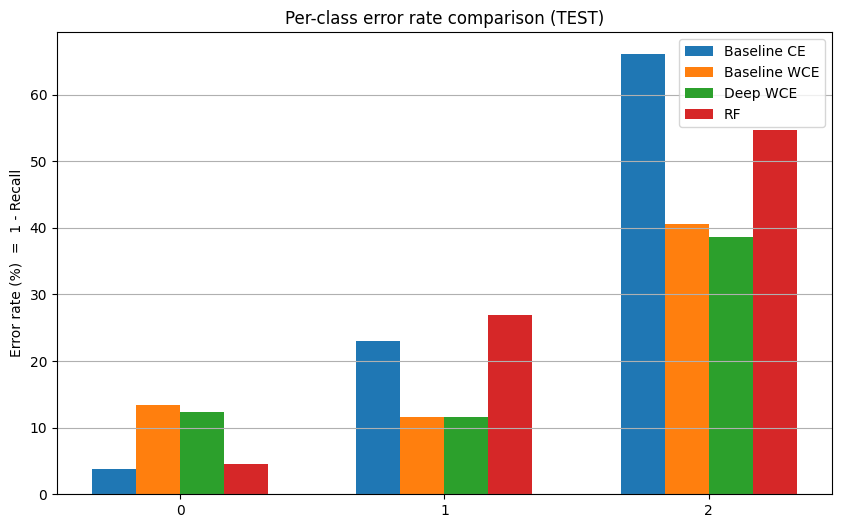

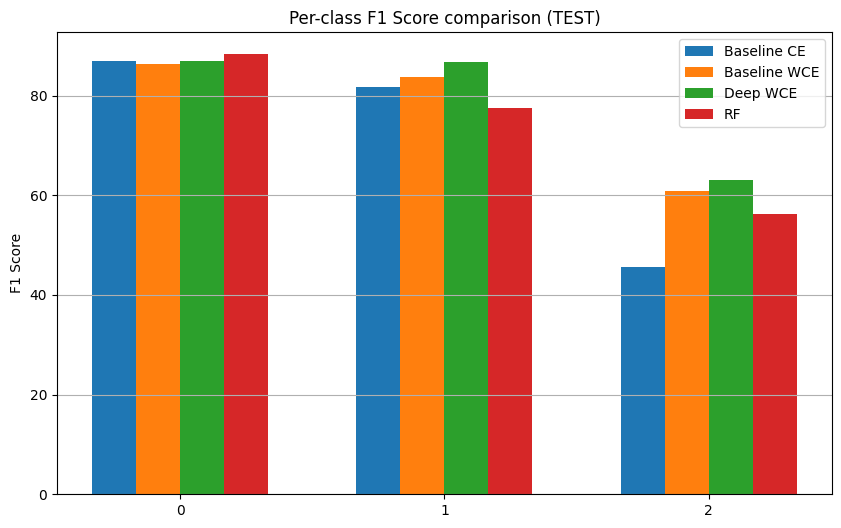

In [ ]:
y_true_b, y_pred_b = collect_preds(pose_model, action_model_base, test_iterator, device, action_labels)
cm_b, err_b, f1_b = print_minimal_report(y_true_b, y_pred_b, class_names=("0","1","2"), title="Baseline CE - TEST")
print("Prediction counts:", count_predictions(pose_model, action_model_base, test_iterator, device))

y_true_bw, y_pred_bw = collect_preds(pose_model, action_model_base_w, test_iterator, device, action_labels)
cm_bw, err_bw, f1_bw = print_minimal_report(y_true_bw, y_pred_bw, class_names=("0","1","2"), title="Baseline WCE - TEST")
print("Prediction counts:", count_predictions(pose_model, action_model_base_w, test_iterator, device))

y_true_d, y_pred_d = collect_preds(pose_model, action_model_deep, test_iterator, device, action_labels)
cm_d, err_d, f1_d = print_minimal_report(y_true_d, y_pred_d, class_names=("0","1","2"), title="Deep WCE - TEST")
print("Prediction counts:", count_predictions(pose_model, action_model_deep, test_iterator, device))

y_true_rf, y_pred_rf = collect_preds(pose_model, rf, test_iterator, device, action_labels, rf = True)
cm_rf, err_rf, f1_rf = print_minimal_report(y_true_rf, y_pred_rf, class_names=("0","1","2"), title="RandomForest - TEST")
print("Prediction counts:", count_predictions(pose_model, rf, test_iterator, device, rf = True))


plot_error_comparison(
    {"Baseline CE": err_b, "Baseline WCE": err_bw, "Deep WCE": err_d, "RF": err_rf},
    class_names=("0","1","2"),
    title="Per-class error rate comparison (TEST)"
)

plot_f1_comparison(
    {"Baseline CE": f1_b, "Baseline WCE": f1_bw, "Deep WCE": f1_d, "RF": f1_rf},
    class_names=("0","1","2"),
    title="Per-class F1 Score comparison (TEST)"
)


## Supervised Learning:

First, we load the labels we manually implemented. They are divided in three classes:

- Class 0: jump-like actions,
- Class 1: low motion actions,
- Class 2: dynamic motion actions.

In [ ]:
labels_true = np.load("/content/labels_true.npy")

In [ ]:
# counts per class
counts = np.bincount(labels_true)
print("Action counts:", counts)

# inverse frequency weighting
weights = 1.0 / counts
weights = weights / weights.sum() * len(counts)

class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

print("Class weights:", class_weights)

print("Train counts:", np.bincount(labels_true[train_idx]))
print("Val counts:",   np.bincount(labels_true[val_idx]))
print("Test counts:",  np.bincount(labels_true[test_idx]))

Action counts: [313 962 725]
Class weights: tensor([1.7074, 0.5555, 0.7371], device='cuda:0')
Train counts: [232 677 491]
Val counts: [30 90 80]
Test counts: [ 51 195 154]


We repeat the same procedure we followed using the clustering *pseudo labels*. We train the models and evaluate the results on the test set.

### Models Training:

**ActionMLP training with normal Cross Entropy**

In [ ]:
# train model
ce_normal = nn.CrossEntropyLoss()

action_model_base_3cl = ActionMLP().to(device)
opt_base = optim.Adam(action_model_base_3cl.parameters(), lr=1e-3)

train_losses_b, train_accs_b, valid_losses_b, valid_accs_b = model_training_action(
    20, pose_model, action_model_base_3cl, train_iterator, val_iterator,
    opt_base, ce_normal, device, labels_true,
    model_name="action_mlp_base_normal_3cl.pt"
)

Epoch 1/20 | Train Loss 1.035 Acc 45.58% | Val Loss 1.008 Acc 43.75%
Epoch 2/20 | Train Loss 0.929 Acc 53.91% | Val Loss 0.953 Acc 46.09%
Epoch 3/20 | Train Loss 0.879 Acc 54.42% | Val Loss 0.870 Acc 43.75%
Epoch 4/20 | Train Loss 0.844 Acc 57.05% | Val Loss 0.858 Acc 43.75%
Epoch 5/20 | Train Loss 0.814 Acc 60.47% | Val Loss 0.829 Acc 50.00%
Epoch 6/20 | Train Loss 0.807 Acc 61.75% | Val Loss 0.852 Acc 43.75%
Epoch 7/20 | Train Loss 0.808 Acc 59.17% | Val Loss 0.851 Acc 44.14%
Epoch 8/20 | Train Loss 0.784 Acc 62.99% | Val Loss 0.875 Acc 43.75%
Epoch 9/20 | Train Loss 0.791 Acc 61.93% | Val Loss 0.843 Acc 46.48%
Epoch 10/20 | Train Loss 0.780 Acc 64.08% | Val Loss 0.812 Acc 51.56%
Epoch 11/20 | Train Loss 0.786 Acc 62.17% | Val Loss 0.823 Acc 47.66%
Epoch 12/20 | Train Loss 0.766 Acc 62.95% | Val Loss 0.875 Acc 48.44%
Epoch 13/20 | Train Loss 0.772 Acc 63.51% | Val Loss 0.840 Acc 51.17%
Epoch 14/20 | Train Loss 0.772 Acc 62.31% | Val Loss 0.829 Acc 50.39%
Epoch 15/20 | Train Loss 0.77

**ActionMLP training with weighted Cross Entropy**

In [ ]:
ce_weighted = nn.CrossEntropyLoss(weight=class_weights)

action_model_base_w_3cl = ActionMLP().to(device)
opt_base_w = optim.Adam(action_model_base_w_3cl.parameters(), lr=1e-3)

train_losses_bw, train_accs_bw, valid_losses_bw, valid_accs_bw = model_training_action(
    30, pose_model, action_model_base_w_3cl, train_iterator, val_iterator,
    opt_base_w, ce_weighted, device, labels_true,
    model_name="action_mlp_base_weighted_3cl.pt"
)

Epoch 1/30 | Train Loss 1.080 Acc 45.54% | Val Loss 1.035 Acc 47.66%
Epoch 2/30 | Train Loss 0.998 Acc 56.75% | Val Loss 0.941 Acc 48.44%
Epoch 3/30 | Train Loss 0.903 Acc 57.04% | Val Loss 0.841 Acc 49.61%
Epoch 4/30 | Train Loss 0.862 Acc 59.00% | Val Loss 0.800 Acc 51.56%
Epoch 5/30 | Train Loss 0.828 Acc 59.62% | Val Loss 0.774 Acc 50.39%
Epoch 6/30 | Train Loss 0.807 Acc 58.94% | Val Loss 0.785 Acc 51.56%
Epoch 7/30 | Train Loss 0.802 Acc 59.95% | Val Loss 0.771 Acc 52.34%
Epoch 8/30 | Train Loss 0.798 Acc 61.25% | Val Loss 0.778 Acc 51.95%
Epoch 9/30 | Train Loss 0.837 Acc 60.77% | Val Loss 0.806 Acc 50.78%
Epoch 10/30 | Train Loss 0.803 Acc 60.66% | Val Loss 0.770 Acc 54.30%
Epoch 11/30 | Train Loss 0.797 Acc 62.73% | Val Loss 0.782 Acc 49.61%
Epoch 12/30 | Train Loss 0.801 Acc 63.59% | Val Loss 0.749 Acc 54.30%
Epoch 13/30 | Train Loss 0.770 Acc 64.21% | Val Loss 0.758 Acc 53.91%
Epoch 14/30 | Train Loss 0.784 Acc 62.94% | Val Loss 0.769 Acc 54.30%
Epoch 15/30 | Train Loss 0.81

**Deep ActionMLP training with weighted Cross Entropy**

In [ ]:
ce_weighted = nn.CrossEntropyLoss(weight=class_weights)

action_model_deep_3cl = ActionMLP_Deep().to(device)
opt_deep = optim.Adam(action_model_deep_3cl.parameters(), lr=1e-3)

train_losses_d, train_accs_d, valid_losses_d, valid_accs_d = model_training_action(
    30, pose_model, action_model_deep_3cl, train_iterator, val_iterator,
    opt_deep, ce_weighted, device, labels_true,
    model_name="action_mlp_deep_weighted_3cl.pt"
)

Epoch 1/30 | Train Loss 0.968 Acc 51.64% | Val Loss 0.885 Acc 56.25%
Epoch 2/30 | Train Loss 0.853 Acc 56.82% | Val Loss 0.771 Acc 53.12%
Epoch 3/30 | Train Loss 0.851 Acc 57.17% | Val Loss 0.817 Acc 55.47%
Epoch 4/30 | Train Loss 0.818 Acc 59.87% | Val Loss 0.793 Acc 53.52%
Epoch 5/30 | Train Loss 0.793 Acc 61.96% | Val Loss 0.795 Acc 52.34%
Epoch 6/30 | Train Loss 0.798 Acc 61.86% | Val Loss 0.814 Acc 55.08%
Epoch 7/30 | Train Loss 0.779 Acc 60.75% | Val Loss 0.780 Acc 56.64%
Epoch 8/30 | Train Loss 0.767 Acc 63.95% | Val Loss 0.784 Acc 56.25%
Epoch 9/30 | Train Loss 0.783 Acc 62.44% | Val Loss 0.780 Acc 60.16%
Epoch 10/30 | Train Loss 0.787 Acc 63.91% | Val Loss 0.788 Acc 57.81%
Epoch 11/30 | Train Loss 0.749 Acc 64.03% | Val Loss 0.736 Acc 62.50%
Epoch 12/30 | Train Loss 0.760 Acc 63.31% | Val Loss 0.740 Acc 58.98%
Epoch 13/30 | Train Loss 0.758 Acc 64.20% | Val Loss 0.784 Acc 61.33%
Epoch 14/30 | Train Loss 0.730 Acc 65.32% | Val Loss 0.757 Acc 60.94%
Epoch 15/30 | Train Loss 0.73

**RandomForest Classifier Training**

In [ ]:
# Extract features
X_train, y_train = extract_pose_joints_rf(pose_model, train_iterator, device, labels_true)
X_val,   y_val   = extract_pose_joints_rf(pose_model, val_iterator,   device, labels_true)

print("Shapes:", X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print("Train counts:", np.bincount(y_train))
print("Val counts:", np.bincount(y_val))

# convert weights to dict
w = torch.tensor([1.7074, 0.5555, 0.7371]).cpu().numpy()
class_weight_rf = {0: float(w[0]), 1: float(w[1]), 2: float(w[2])}

# Fit RF
rf = RandomForestClassifier(
    n_estimators=600,
    min_samples_leaf=2,
    random_state=44,
    n_jobs=-1,
    class_weight=class_weight_rf
)
rf.fit(X_train, y_train)

# Evaluate on validation set
pred_val = rf.predict(X_val)

print("VAL acc:", accuracy_score(y_val, pred_val))
print("VAL macro-F1:", f1_score(y_val, pred_val, average="macro"))
print("VAL confusion:\n", confusion_matrix(y_val, pred_val))
print("\nVAL report:\n", classification_report(y_val, pred_val))

Shapes: (1400, 28) (1400,) (200, 28) (200,)
Train counts: [232 677 491]
Val counts: [30 90 80]
VAL acc: 0.665
VAL macro-F1: 0.6705115967990084
VAL confusion:
 [[21  4  5]
 [ 4 68 18]
 [ 4 32 44]]

VAL report:
               precision    recall  f1-score   support

           0       0.72      0.70      0.71        30
           1       0.65      0.76      0.70        90
           2       0.66      0.55      0.60        80

    accuracy                           0.67       200
   macro avg       0.68      0.67      0.67       200
weighted avg       0.67      0.67      0.66       200



### Evaluation on the Test Set:

In [ ]:
# load best models
action_base_path_3cl = "action_mlp_base_normal_3cl.pt"
action_weighted_path_3cl = "action_mlp_base_weighted_3cl.pt"
action_deepw_path_3cl = "action_mlp_deep_weighted_3cl.pt"

action_model_base_3cl.load_state_dict(torch.load(action_base_path_3cl, map_location = device))
action_model_base_w_3cl.load_state_dict(torch.load(action_weighted_path_3cl, map_location = device))
action_model_deep_3cl.load_state_dict(torch.load(action_deepw_path_3cl, map_location = device))

<All keys matched successfully>

In [ ]:
# # to use saved weights

# ACTION_BASE_PATH_3cl = "/content/checkpoints/checkpoints/action_mlp_base_normal_3cl.pt"
# ACTION_WEIGHTED_PATH_3cl = "/content/checkpoints/checkpoints/action_mlp_base_weighted_3cl.pt"
# ACTION_DEEPW_PATH_3cl = "/content/checkpoints/checkpoints/action_mlp_deep_weighted_3cl.pt"

# action_model_base_3cl = ActionMLP().to(device)
# action_model_base_3cl.load_state_dict(torch.load(ACTION_BASE_PATH_3cl, map_location=device))

# action_model_base_w_3cl = ActionMLP().to(device)
# action_model_base_w_3cl.load_state_dict(torch.load(ACTION_WEIGHTED_PATH_3cl, map_location=device))

# action_model_deep_3cl = ActionMLP_Deep().to(device)
# action_model_deep_3cl.load_state_dict(torch.load(ACTION_DEEPW_PATH_3cl, map_location=device))

<All keys matched successfully>


Baseline CE - TEST
true\pred |      0 |      1 |      2
------------------------------------
        0 |     37 |      2 |     12
        1 |      7 |    155 |     33
        2 |     11 |     73 |     70

Per-class error rate (1 - recall):
  Class 0: 27.45%
  Class 1: 20.51%
  Class 2: 54.55%

Per-class F1 score:
  Class 0: 0.698
  Class 1: 0.729
  Class 2: 0.520
Prediction counts: [ 55 230 115]

Baseline WCE - TEST
true\pred |      0 |      1 |      2
------------------------------------
        0 |     44 |      0 |      7
        1 |     20 |    116 |     59
        2 |     20 |     42 |     92

Per-class error rate (1 - recall):
  Class 0: 13.73%
  Class 1: 40.51%
  Class 2: 40.26%

Per-class F1 score:
  Class 0: 0.652
  Class 1: 0.657
  Class 2: 0.590
Prediction counts: [ 84 158 158]

Deep WCE - TEST
true\pred |      0 |      1 |      2
------------------------------------
        0 |     44 |      1 |      6
        1 |     20 |    145 |     30
        2 |     14 |     49 |     

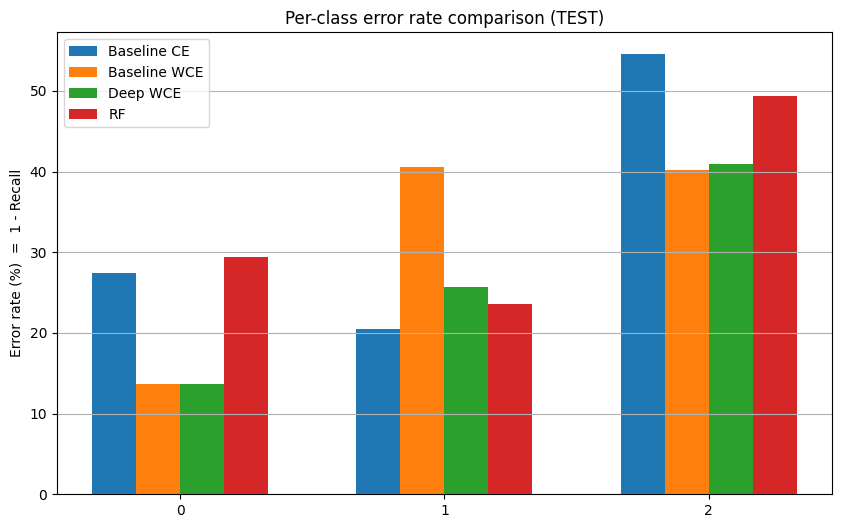

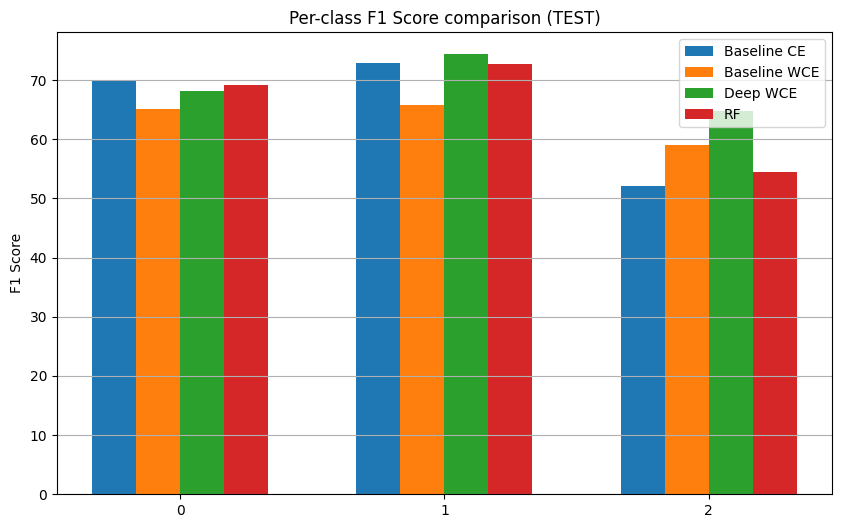

In [ ]:
y_true_b, y_pred_b = collect_preds(pose_model, action_model_base_3cl, test_iterator, device, labels_true)
cm_b, err_b, f1_b = print_minimal_report(y_true_b, y_pred_b, class_names=("0","1","2"), title="Baseline CE - TEST")
print("Prediction counts:", count_predictions(pose_model, action_model_base_3cl, test_iterator, device))

y_true_bw, y_pred_bw = collect_preds(pose_model, action_model_base_w_3cl, test_iterator, device, labels_true)
cm_bw, err_bw, f1_bw = print_minimal_report(y_true_bw, y_pred_bw, class_names=("0","1","2"), title="Baseline WCE - TEST")
print("Prediction counts:", count_predictions(pose_model, action_model_base_w_3cl, test_iterator, device))

y_true_d, y_pred_d = collect_preds(pose_model, action_model_deep_3cl, test_iterator, device, labels_true)
cm_d, err_d, f1_d = print_minimal_report(y_true_d, y_pred_d, class_names=("0","1","2"), title="Deep WCE - TEST")
print("Prediction counts:", count_predictions(pose_model, action_model_deep_3cl, test_iterator, device))

y_true_rf, y_pred_rf = collect_preds(pose_model, rf, test_iterator, device, labels_true, rf = True)
cm_rf, err_rf, f1_rf = print_minimal_report(y_true_rf, y_pred_rf, class_names=("0","1","2"), title="RandomForest - TEST")
print("Prediction counts:", count_predictions(pose_model, rf, test_iterator, device, rf = True))


plot_error_comparison(
    {"Baseline CE": err_b, "Baseline WCE": err_bw, "Deep WCE": err_d, "RF": err_rf},
    class_names=("0","1","2"),
    title="Per-class error rate comparison (TEST)"
)

plot_f1_comparison(
    {"Baseline CE": f1_b, "Baseline WCE": f1_bw, "Deep WCE": f1_d, "RF": f1_rf},
    class_names=("0","1","2"),
    title="Per-class F1 Score comparison (TEST)"
)
